In [38]:
import os
import random
import shap
import torch.nn as nn 
import re
#from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from torch import optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output
from sklearn.decomposition import PCA
from pytorch_metric_learning import losses
# from sklearn.preprocessing import MinMaxScaler
# import math
# import time
# import json
# from datetime import datetime
# from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")


In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

cpu


In [40]:
LLM = "bert-base-uncased"
# LLM = "bert-large-uncased"
# LLM = "albert"
# LLM = "roberta"
# LLM = "xlm"

In [41]:
lv1_lv3 = dict({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2})

In [42]:
class DATA():

    def __init__(self):
        self.dataset_llm = []
        self.dataset_opensmile = []
        self.dataset_cps_f = []
        self.dataset_cps_i = []
        self.dataset_action = []
        self.dataset_gamr = []

        self.targets = []

    def openLLM(self, filename):
        data = pd.read_csv(filename)
        for i in range(len(data)):
            self.dataset_llm.append(np.asarray(data.iloc[i]).tolist())
        global llm_size
        llm_size = len(self.dataset_llm[-1])
    
    
    def openSmile(self,filename):
        data = pd.read_csv(filename)
        for i in range (data.shape[0]):
            # print(f'C:\\Users\\Bbykitty\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav')
            row=data[data['file']==f'C:\\Users\\bradf\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav']
            tensor=np.nan_to_num(np.asarray(row.values[0][3:91],dtype=np.float32)).tolist()
            self.dataset_opensmile.append(tensor)


    def openCPS(self, filename):
        data = pd.read_csv(filename).fillna(0)
        for row in range(data.shape[0]):
            cps = data.iloc[row, 8:].fillna(0)
            self.dataset_cps_i.append(list(cps.values))
            cps_f = [0, 0, 0]
            for i, c in enumerate(list(cps.values)):
                if c == 1:
                    cps_f[lv1_lv3[i]] = 1
            self.dataset_cps_f.append(cps_f)

    def openAction(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_action.append(data.iloc[row].to_list())



    def openGAMR(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_gamr.append(data.iloc[row].to_list())
        

    def openTarget(self,filename):
        data = pd.read_csv(filename)
        for row in range(data.shape[0]):
            target = data.iloc[row, 3:].values.astype(int)
            self.targets.append(target.tolist())


    def get_datasets(self, rand=False):
        final_dataset=[]        
        for llm, opensmile, cps_f, cps_i, action, gamr, label in zip(self.dataset_llm, self.dataset_opensmile,self.dataset_cps_f, self.dataset_cps_i, self.dataset_action, self.dataset_gamr, self.targets):
            final_dataset.append([llm, opensmile, cps_f, cps_i, action, gamr, label])
            
        if rand:
            random.shuffle(final_dataset)
        return final_dataset

In [43]:
def read_data(dataset, root, file, llm="bert-base-uncased"):

    if llm in file:
        dataset.openLLM(root+"/"+file)
    if 'oracle_opensmile' in file:
        dataset.openSmile(root+"/"+file)
    elif 'CPS_Oracle' in file:
        dataset.openCPS(root+"/"+file)
    elif "Actions_Oracle_vectors" in file:
        dataset.openAction(root+"/"+file)
    elif "GAMR_Oracle_vectors" in file:
        dataset.openGAMR(root+"/"+file)
    elif 'CG_3_gold.csv' in file:
        dataset.openTarget(root+"/"+file)
        

In [44]:
train_datasets = DATA()

In [45]:
for root, dirs,files in (os.walk(os. getcwd())):
    if "Group_" in root:
        if "asr" not in root:
            print(root)
            for file in files:
                read_data(train_datasets, root, file, LLM)

/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_05
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_02
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_03
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_04
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_10
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_08
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_01
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_06
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_07
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_09


In [46]:
len(train_datasets.dataset_llm),\
len(train_datasets.dataset_opensmile),\
len(train_datasets.dataset_cps_f),\
len(train_datasets.dataset_cps_i),\
len(train_datasets.dataset_action),\
len(train_datasets.dataset_gamr),\
len(train_datasets.targets)

(2873, 2873, 2873, 2873, 2873, 2873, 2873)

In [47]:
len(train_datasets.dataset_llm) == len(train_datasets.dataset_opensmile) == len(train_datasets.dataset_cps_f) == len(train_datasets.dataset_cps_i) == len(train_datasets.dataset_action) == len(train_datasets.dataset_gamr) == len(train_datasets.targets)

True

In [48]:
np.sum(np.asarray(train_datasets.targets))

271

In [49]:
np.sum(np.asarray(train_datasets.targets), axis=0)

array([195,  61,  15])

In [50]:
def change_window_size(train_list, window_size):
    rec_train_list = []
    pad = [[0]*len(train_list[0][0]), [0]*len(train_list[0][1])]

    for utt_id in range(len(train_list)):
        aux = []
        for i in range(window_size):
            if utt_id == i:
                for _ in range(window_size-utt_id):
                    aux.append(pad)
        for i in range(window_size):
            if len(aux) == i:
                aux.append(train_list[utt_id - window_size + i])
        aux.append(train_list[utt_id])
        rec_train_list.append(aux)
    
    return rec_train_list

In [51]:
window_size = 3

In [52]:
def get_data(k, j, window_size):
    full_data = []
    for group in range(1, 11):
        if group != k and group != j:
            train_datasets = DATA()
            for root, dirs,files in (os.walk(os. getcwd())):
                if f"Group_{group:02d}" in root:
                    if "asr" not in root:
                        print(root)
                        for file in files:
                            read_data(train_datasets, root, file, LLM)
            train_list = train_datasets.get_datasets()
            train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
            rec_train_list = change_window_size(train_list, window_size)
            full_data += rec_train_list
        # random.shuffle(full_data)
    return full_data

In [53]:
def get_group_k(k, window_size):
    full_data = []
    group = k
    train_datasets = DATA()
    for root, dirs,files in (os.walk(os. getcwd())):
        if f"Group_{group:02d}" in root:
            if "asr" not in root:
                print(root)
                for file in files:
                    read_data(train_datasets, root, file, LLM)
    train_list = train_datasets.get_datasets()
    train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
    rec_train_list = change_window_size(train_list, window_size)
    full_data += rec_train_list
    # random.shuffle(full_data)
    return full_data

In [54]:
# Uncomment to remove utterances with no CGA
def remove_non_cga(full_data):
    utt_id = 0
    while utt_id  < (len(full_data)):
        if full_data[utt_id][-1][1] == [0, 0, 0]:
            del full_data[utt_id]
        else:
            utt_id += 1
    return full_data

In [55]:
test_group = 2 # Must hold out group 2 (it contains 1 of each class which we need for auroc)
val_group = 5
train_data = get_data(test_group, val_group, window_size)
test_data = get_group_k(test_group, window_size)
val_data = get_group_k(val_group, window_size)

/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_01
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_03
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_04
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_06
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_07
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_08
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_09
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_10
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_02
/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_05


In [56]:
train_data = remove_non_cga(train_data)
test_data = remove_non_cga(test_data)
val_data = remove_non_cga(val_data)

In [57]:
class rec_dataset(Dataset):
    def __init__(self,xy=None, window_size=3):
        self.utt_bert_l = []
        self.utt_open_l = []
        self.utt_cps_f_l = []
        self.utt_cps_i_l = []
        self.utt_action_l = []
        self.utt_gamr_l = []
        self.utt_y_l = []
        self.utt_y = []

        for utt in xy:
            bert_tmp = []
            open_tmp = []
            cps_i_tmp = []
            cps_f_tmp = []
            action_tmp = []
            gamr_tmp = []
            y_tmp = []
            for utt_id in range(window_size+1):
                bert_tmp.append(utt[utt_id][0][:llm_size])
                open_tmp.append(utt[utt_id][0][llm_size:llm_size+88])
                cps_i_tmp.append(utt[utt_id][0][llm_size+88:llm_size+88+19])
                cps_f_tmp.append(utt[utt_id][0][llm_size+88+19:llm_size+88+19+3])
                action_tmp.append(utt[utt_id][0][llm_size+88+19+3:llm_size+88+19+3+78])
                gamr_tmp.append(utt[utt_id][0][llm_size+88+19+3+78:])
                y_tmp.append(utt[utt_id][1])
            self.utt_bert_l.append(bert_tmp)
            self.utt_open_l.append(open_tmp)
            self.utt_cps_f_l.append(cps_f_tmp)
            self.utt_cps_i_l.append(cps_i_tmp)
            self.utt_action_l.append(action_tmp)
            self.utt_gamr_l.append(gamr_tmp)
            self.utt_y_l.append(y_tmp)
        self.utt_bert_l = torch.from_numpy(np.asarray(self.utt_bert_l,dtype=np.float32))
        self.utt_open_l = torch.from_numpy(np.asarray(self.utt_open_l,dtype=np.float32))
        self.utt_cps_f_l = torch.from_numpy(np.asarray(self.utt_cps_f_l,dtype=np.float32))
        self.utt_cps_i_l = torch.from_numpy(np.asarray(self.utt_cps_i_l,dtype=np.float32))
        self.utt_action_l = torch.from_numpy(np.asarray(self.utt_action_l,dtype=np.float32))
        self.utt_gamr_l = torch.from_numpy(np.asarray(self.utt_gamr_l,dtype=np.float32))
        self.utt_y_l = torch.from_numpy(np.asarray(self.utt_y_l,dtype=np.float32))

        for utt_id in range(len(self.utt_y_l)):
            self.utt_y.append(self.utt_y_l[utt_id][-1])

        self.len=len(self.utt_bert_l)
        

    def __getitem__(self, index):
        return self.utt_bert_l[index], self.utt_open_l[index], self.utt_cps_f_l[index], self.utt_cps_i_l[index], self.utt_action_l[index], self.utt_gamr_l[index], self.utt_y[index]
    
    def get_labels(self):
        return np.stack(self.utt_y, axis=0).argmax(axis=1)

    def __len__(self):
        return self.len

In [58]:
train_dataset = rec_dataset(train_data, window_size)
test_dataset = rec_dataset(test_data, window_size)
val_dataset = rec_dataset(val_data, window_size)

In [59]:
def smote_preprocess(train_dataset, window_size):
    x_bert = []
    x_open = []
    x_cps_i = []
    x_cps_f = []
    x_action = []
    x_gamr = []
    y = []
    for i in range(len(train_dataset)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for j in range(len(train_dataset.utt_open_l[i])):
            x_bert_tmp += train_dataset.utt_bert_l[i][j].tolist()
            x_open_tmp += train_dataset.utt_open_l[i][j].tolist()
            x_cps_i_tmp += train_dataset.utt_cps_i_l[i][j].tolist()
            x_cps_f_tmp += train_dataset.utt_cps_f_l[i][j].tolist()
            x_action_tmp += train_dataset.utt_action_l[i][j].tolist()
            x_gamr_tmp += train_dataset.utt_gamr_l[i][j].tolist()

        y.append(train_dataset.utt_y[i].tolist())
        x_bert.append(x_bert_tmp)
        x_open.append(x_open_tmp)
        x_cps_i.append(x_cps_i_tmp)
        x_cps_f.append(x_cps_f_tmp)
        x_action.append(x_action_tmp)
        x_gamr.append(x_gamr_tmp)

        if y[-1] == [0, 0, 1]:
            for _ in range(2):
                y.append(train_dataset.utt_y[i].tolist())
                x_bert.append(x_bert_tmp)
                x_open.append(x_open_tmp)
                x_cps_i.append(x_cps_i_tmp)
                x_cps_f.append(x_cps_f_tmp)
                x_action.append(x_action_tmp)
                x_gamr.append(x_gamr_tmp)
        

    oversample = SMOTE()

    x_bert, y_ = oversample.fit_resample(np.array(x_bert), np.array(y))
    x_open, y_ = oversample.fit_resample(np.array(x_open), np.array(y))
    x_cps_i, y_ = oversample.fit_resample(np.array(x_cps_i), np.array(y))
    x_cps_f, y_ = oversample.fit_resample(np.array(x_cps_f), np.array(y))
    x_action, y_ = oversample.fit_resample(np.array(x_action), np.array(y))
    x_gamr, y_ = oversample.fit_resample(np.array(x_gamr), np.array(y))
    clear_output(wait=False)



    x_bert_tensor = []
    x_open_tensor = []
    x_cps_i_tensor = []
    x_cps_f_tensor = []
    x_action_tensor = []
    x_gamr_tensor = []
    y = []
    for i in range(len(x_bert)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for utt_id in range(window_size+1):
            bert_size = int(len(x_bert[i])/(window_size + 1))
            open_size = int(len(x_open[i])/(window_size + 1))
            cps_i_size = int(len(x_cps_i[i])/(window_size + 1))
            cps_f_size = int(len(x_cps_f[i])/(window_size + 1))
            action_size = int(len(x_action[i])/(window_size + 1))
            gamr_size = int(len(x_gamr[i])/(window_size + 1))

            x_bert_tmp.append(x_bert[i][utt_id*bert_size:(utt_id+1)*bert_size])
            x_open_tmp.append(x_open[i][utt_id*open_size:(utt_id+1)*open_size])
            x_cps_i_tmp.append(x_cps_i[i][utt_id*cps_i_size:(utt_id+1)*cps_i_size])
            x_cps_f_tmp.append(x_cps_f[i][utt_id*cps_f_size:(utt_id+1)*cps_f_size])
            x_action_tmp.append(x_action[i][utt_id*action_size:(utt_id+1)*action_size])
            x_gamr_tmp.append(x_gamr[i][utt_id*gamr_size:(utt_id+1)*gamr_size])

        x_bert_tensor.append(x_bert_tmp)
        x_open_tensor.append(x_open_tmp)
        x_cps_i_tensor.append(x_cps_i_tmp)
        x_cps_f_tensor.append(x_cps_f_tmp)
        x_action_tensor.append(x_action_tmp)
        x_gamr_tensor.append(x_gamr_tmp)
        y.append(torch.Tensor(y_[i]))

    x_bert_tensor = torch.from_numpy(np.array(x_bert_tensor, dtype=np.float32))
    x_open_tensor = torch.from_numpy(np.array(x_open_tensor, dtype=np.float32))
    x_cps_i_tensor = torch.from_numpy(np.array(x_cps_i_tensor, dtype=np.float32))
    x_cps_f_tensor = torch.from_numpy(np.array(x_cps_f_tensor, dtype=np.float32))
    x_action_tensor = torch.from_numpy(np.array(x_action_tensor, dtype=np.float32))
    x_gamr_tensor = torch.from_numpy(np.array(x_gamr_tensor, dtype=np.float32))


    train_dataset.utt_bert_l = x_bert_tensor
    train_dataset.utt_open_l = x_open_tensor
    train_dataset.utt_cps_i_l = x_cps_i_tensor
    train_dataset.utt_cps_f_l = x_cps_f_tensor
    train_dataset.utt_action_l = x_action_tensor
    train_dataset.utt_gamr_l = x_gamr_tensor
    train_dataset.utt_y = y
    train_dataset.len = len(train_dataset.utt_y)

In [60]:
smote_preprocess(train_dataset, window_size)

In [61]:
# rec_train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset),batch_size=16)
# rec_test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset),batch_size=16)
rec_train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
rec_test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
rec_val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [62]:
# y_train = rec_dataset(rec_train_list, window_size).utt_y
y_train = train_dataset.utt_y

In [63]:
y_train_tensor = torch.stack(y_train)

In [64]:
print(y_train_tensor.argmax(dim=1).unique(return_counts=True))

(tensor([0, 1, 2]), tensor([149, 149, 149]))


In [65]:
class rec_common_ground(nn.Module):
    def __init__(self, hyperparam, modalities, output_size=1):
        super(rec_common_ground, self).__init__()

        lin_layers = hyperparam["lin_layers"]
        hidden_size = hyperparam["hidden_size"]
        lstm_hidden_size = hyperparam["lstm_hidden_size"]
        lstm_input_size = hyperparam["lstm_input_size"]
        ff1_size = hyperparam["ff1_size"]
        ff2_size = hyperparam["ff2_size"]

        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]

        self.lin_bert1 = nn.Linear(llm_size, hidden_size)
        self.lin_bert2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_bert = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_bert = nn.LSTM(input_size=llm_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_open1 = nn.Linear(88, hidden_size)
        self.lin_open2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_opensmile = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_opensmile = nn.LSTM(input_size=88, batch_first=True, hidden_size=lstm_hidden_size)

        cps_size = 19
        if cps_f_b:
            cps_size = 3
        self.lin_cps1 = nn.Linear(cps_size, hidden_size)
        self.lin_cps2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_cps = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_cps = nn.LSTM(input_size=cps_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_action1 = nn.Linear(78, hidden_size)
        self.lin_action2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_action = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_action = nn.LSTM(input_size=78, batch_first=True, hidden_size=lstm_hidden_size)

        self.lin_gamr1 = nn.Linear(243, hidden_size)
        self.lin_gamr2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_gamr = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_gamr = nn.LSTM(input_size=243, batch_first=True, hidden_size=lstm_hidden_size)


        self.relu = nn.ReLU()
        n_modals = int(bert_b) + int(opensmile_b) + int(cps_b) + int(action_b) + int(gamr_b)
        self.ff1 = nn.Linear(lstm_hidden_size*n_modals, ff1_size)
        self.ff2 = nn.Linear(ff1_size, ff2_size)
        self.act1 = nn.Tanh()
        self.act2 = nn.SiLU()
        self.classifier = nn.Linear(ff2_size, output_size)


    def forward(self, utt_bert_l, utt_open_l, utt_cps_l, utt_action_l, utt_gamr_l, hyperparam, modalities):


        lin_layers = hyperparam["lin_layers"]
        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]


        if bert_b:
            if lin_layers:
                utt_bert_l = [self.lin_bert1(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.lin_bert2(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.relu(utt_x_bert) for utt_x_bert in utt_bert_l]
            bert = torch.stack(tuple(utt_bert_l), dim=0)
            bert = self.lstm_bert(bert)[1][0][0]

        if opensmile_b:
            if lin_layers:
                utt_open_l = [self.lin_open1(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.lin_open2(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.relu(utt_x_open) for utt_x_open in utt_open_l]
            opensmile = torch.stack(tuple(utt_open_l), dim=0)
            opensmile = self.lstm_opensmile(opensmile)[1][0][0]

        if cps_b:
            if lin_layers:
                utt_cps_l = [self.lin_cps1(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.lin_cps2(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.relu(utt_x_cps) for utt_x_cps in utt_cps_l]
                # utt_cps_l shape = batch_size, window_size+1, 256
            cps = torch.stack(tuple(utt_cps_l), dim=0)
            cps = self.lstm_cps(cps)[1][0][0]

        if action_b:
            if lin_layers:
                utt_action_l = [self.lin_action1(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.lin_action2(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.relu(utt_x_action) for utt_x_action in utt_action_l]
            action = torch.stack(tuple(utt_action_l), dim=0)
            action = self.lstm_action(action)[1][0][0]

        if gamr_b:
            if lin_layers:
                utt_gamr_l = [self.lin_gamr1(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.lin_gamr2(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.relu(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
            gamr = torch.stack(tuple(utt_gamr_l), dim=0)
            gamr = self.lstm_gamr(gamr)[1][0][0]

        modals = []
        if bert_b: modals.append(bert)
        if opensmile_b: modals.append(opensmile)
        if cps_b: modals.append(cps)
        if action_b: modals.append(action)
        if gamr_b: modals.append(gamr)


        x = torch.hstack(tuple(modals))
        x = self.ff1(x)
        x = self.act1(x)
        x = self.ff2(x)
        x = self.act2(x)
        predict = self.classifier(x)

        return predict


    def get_embeddings(self, utt_bert_l, utt_open_l, utt_cps_l, utt_action_l, utt_gamr_l, hyperparam, modalities):


        lin_layers = hyperparam["lin_layers"]
        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]


        if bert_b:
            if lin_layers:
                utt_bert_l = [self.lin_bert1(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.lin_bert2(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.relu(utt_x_bert) for utt_x_bert in utt_bert_l]
            bert = torch.stack(tuple(utt_bert_l), dim=0)
            bert = self.lstm_bert(bert)[1][0][0]

        if opensmile_b:
            if lin_layers:
                utt_open_l = [self.lin_open1(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.lin_open2(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.relu(utt_x_open) for utt_x_open in utt_open_l]
            opensmile = torch.stack(tuple(utt_open_l), dim=0)
            opensmile = self.lstm_opensmile(opensmile)[1][0][0]

        if cps_b:
            if lin_layers:
                utt_cps_l = [self.lin_cps1(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.lin_cps2(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.relu(utt_x_cps) for utt_x_cps in utt_cps_l]
                # utt_cps_l shape = batch_size, window_size+1, 256
            cps = torch.stack(tuple(utt_cps_l), dim=0)
            cps = self.lstm_cps(cps)[1][0][0]

        if action_b:
            if lin_layers:
                utt_action_l = [self.lin_action1(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.lin_action2(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.relu(utt_x_action) for utt_x_action in utt_action_l]
            action = torch.stack(tuple(utt_action_l), dim=0)
            action = self.lstm_action(action)[1][0][0]

        if gamr_b:
            if lin_layers:
                utt_gamr_l = [self.lin_gamr1(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.lin_gamr2(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.relu(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
            gamr = torch.stack(tuple(utt_gamr_l), dim=0)
            gamr = self.lstm_gamr(gamr)[1][0][0]

        modals = []
        if bert_b: modals.append(bert)
        if opensmile_b: modals.append(opensmile)
        if cps_b: modals.append(cps)
        if action_b: modals.append(action)
        if gamr_b: modals.append(gamr)


        x = torch.hstack(tuple(modals))
        x = self.ff1(x)
        x = self.act1(x)
        x = self.ff2(x)
        x = self.act2(x)

        return x


In [66]:
def rec_train(model, total_epochs, lr, train_loader, class_to_eval, hyperparam, modalities, output_size):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_loss = []
    nepochs = 0
    cps_f_b = modalities["cps_f_b"]
    model.train()

    criterion = nn.BCELoss(reduction='mean').to(device)
    if output_size != 1:
        # criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
    while nepochs < total_epochs :
        batch_loss = []
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in train_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                target_binary = torch.zeros(target.size()[0], 1).to(device)
                for i,t in enumerate(target):
                    target_binary[i] = torch.Tensor([t[class_to_eval]])
                loss = criterion(torch.sigmoid(output), target_binary)
            else:
                loss = criterion(output, target)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        nepochs += 1
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model, epoch_loss

In [67]:
def rec_test(model, test_loader, class_to_eval, hyperparam, modalities, output_size):
    with torch.no_grad():
        model.eval()
        cps_f_b = modalities["cps_f_b"]
        true, pred = None, None
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in test_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                pred_tmp = torch.sigmoid(output)
                true_binary = torch.zeros(target.size()[0], 1)
                for i, t in enumerate(target):
                    true_binary[i] = torch.Tensor([t[class_to_eval]])
                if true == None:
                    true = true_binary
                    pred = pred_tmp > 0.5
                    pred_probs = pred_tmp

                else :
                    true = torch.cat((true, true_binary))
                    pred = torch.cat((pred, pred_tmp > 0.5))
                    pred_probs = torch.cat((pred_probs, pred_tmp))
                    
            
            else:
                softmax = torch.nn.Softmax(dim=1)
                target_ = torch.clone(target)
                true_tmp = target_.cpu().numpy()
                preds_tmp = softmax(output).cpu().detach().numpy()

                if true == None:
                    true = torch.argmax(torch.from_numpy(true_tmp), dim=1)
                    pred = torch.argmax(torch.from_numpy(preds_tmp), dim=1)
                    pred_probs = torch.tensor(preds_tmp)
                else:
                    true = torch.cat((true, torch.argmax(torch.from_numpy(true_tmp), dim=1)))
                    pred = torch.cat((pred, torch.argmax(torch.from_numpy(preds_tmp), dim=1)))
                    pred_probs = torch.cat((pred_probs, torch.tensor(preds_tmp)))
        
    return true.int().cpu(), pred.int().cpu(), pred_probs.cpu()


In [ ]:
def triplet_train(model, total_epochs, lr, train_loader, hyperparam, modalities, output_size):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_loss = []
    cps_f_b = modalities["cps_f_b"]
    model.train()
    # miner = miners.MultiSimilarityMiner()
    loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)
    loss_func = losses.AngularLoss(alpha=40)
    loss_func = losses.CircleLoss(m=0.4, gamma=80)
    loss_func = losses.TripletMarginLoss()
    for _ in range(total_epochs) :
        batch_loss = []
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in train_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            embeddings = model.get_embeddings(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            target = utt_y.to(device)
            target = target.argmax(axis=1)
            # hard_pairs = miner(embeddings, target)
            # loss = loss_func(embeddings, target, hard_pairs)
            loss = loss_func(embeddings, target)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model, epoch_loss

In [ ]:
torch.manual_seed(30)
torch.cuda.manual_seed(30)

In [68]:
# model weight initialization
def model_initilization(model):
    b = True
    for layer in model.modules():
        if b:
            b = False
        else:
            try:
                #torch.nn.init.xavier_uniform(layer.weight)
                torch.nn.init.kaiming_uniform(layer.weight)
                layer.bias.data.fill_(0.01)
            except:
                continue
    return model

In [78]:
hyperparam = {"lin_layers":True, "hidden_size":512, "lstm_hidden_size":512, "lstm_input_size":128, "ff1_size":256, "ff2_size":384}
modalities = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}

In [80]:
output_size = 3
model = rec_common_ground(hyperparam, modalities, output_size=output_size)
model.to(device)
model = model_initilization(model)

In [785]:
# model = torch.load("multinomial_3.pt",map_location=torch.device('cpu'))

In [ ]:
model, epoch_loss = triplet_train(model, 200, 0.0001, rec_train_loader, hyperparam, modalities, output_size)

In [786]:
model, epoch_loss = rec_train(model, 100, 0.001, rec_train_loader, 2, hyperparam, modalities, output_size)

In [ ]:
model, epoch_loss = rec_train(model, 200, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)

In [787]:
# epoch_loss

In [788]:
true, pred, pred_probs = rec_test(model, rec_test_loader, 2, hyperparam, modalities, output_size)

In [789]:
print(true.unique(return_counts=True))
print(pred.unique(return_counts=True))

(tensor([0, 1, 2], dtype=torch.int32), tensor([5, 6, 2]))
(tensor([0, 1], dtype=torch.int32), tensor([4, 9]))


In [790]:
labels = ["Statement", "Accept", "Doubt"]

(array([0, 1, 2]),
 [Text(0, 0, 'Statement'), Text(1, 0, 'Accept'), Text(2, 0, 'Doubt')])

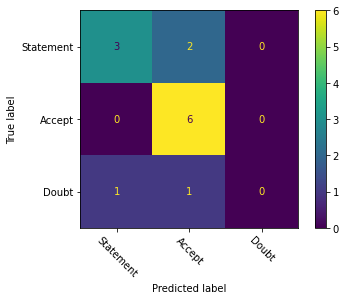

In [791]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)

In [284]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

# if output_size == 1:
#     auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
# else: 
#     auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [285]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

print(f"auroc : {auroc:.4f}")

accuracy : 0.4444

micro f1_score : 0.4444
macro f1_score : 0.4156
weighted f1_score : 0.4733

micro precision : 0.4444
macro precision : 0.4444
weighted precision : 0.5432

micro recall : 0.4444
macro recall : 0.4308
weighted recall : 0.4444

auroc : 0.5639


(array([0, 1, 2]),
 [Text(0, 0, 'Statement'), Text(1, 0, 'Accept'), Text(2, 0, 'Doubt')])

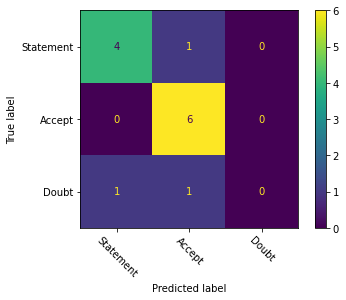

In [134]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)

In [135]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

# if output_size == 1:
#     auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
# else: 
#     auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [136]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

# print(f"auroc : {auroc:.4f}")

accuracy : 0.7692

micro f1_score : 0.7692
macro f1_score : 0.5524
weighted f1_score : 0.7033

micro precision : 0.7692
macro precision : 0.5167
weighted precision : 0.6538

micro recall : 0.7692
macro recall : 0.6000
weighted recall : 0.7692



In [276]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/nikhil/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [277]:
import common_ground
import utt_encoding
import importlib
importlib.reload(common_ground)
importlib.reload(utt_encoding)
from common_ground import CommonGround
from utt_encoding import UtteranceEncoding

import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [255]:
utterance_encoder = UtteranceEncoding()

red block equals ten
red block equals twenty
red block equals thirty
red block equals forty
red block equals fifty
red block equals blue block
red block equals green block
red block equals purple block
red block equals yellow block
red block equals blue block plus green block
red block equals blue block plus purple block
red block equals blue block plus yellow block
red block equals green block plus purple block
red block equals green block plus yellow block
red block equals purple block plus yellow block
red block equals blue block plus green block plus purple block
red block equals blue block plus green block plus yellow block
red block equals blue block plus purple block plus yellow block
red block equals green block plus purple block plus yellow block
red block equals blue block plus green block plus purple block plus yellow block
red block does not equal ten
red block does not equal twenty
red block does not equal thirty
red block does not equal forty
red block does not equal fift

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0 Encoding red block equals ten
Summed embeddings shape is: 6 x 768
1 Encoding red block equals twenty
Summed embeddings shape is: 6 x 768
2 Encoding red block equals thirty
Summed embeddings shape is: 6 x 768
3 Encoding red block equals forty
Summed embeddings shape is: 6 x 768
4 Encoding red block equals fifty
Summed embeddings shape is: 6 x 768
5 Encoding red block equals blue block
Summed embeddings shape is: 7 x 768
6 Encoding red block equals green block
Summed embeddings shape is: 7 x 768
7 Encoding red block equals purple block
Summed embeddings shape is: 7 x 768
8 Encoding red block equals yellow block
Summed embeddings shape is: 7 x 768
9 Encoding red block equals blue block plus green block
Summed embeddings shape is: 10 x 768
10 Encoding red block equals blue block plus purple block
Summed embeddings shape is: 10 x 768
11 Encoding red block equals blue block plus yellow block
Summed embeddings shape is: 10 x 768
12 Encoding red block equals green block plus purple block
Sum

Summed embeddings shape is: 10 x 768
90 Encoding blue block equals red block plus purple block
Summed embeddings shape is: 10 x 768
91 Encoding blue block equals red block plus yellow block
Summed embeddings shape is: 10 x 768
92 Encoding blue block equals green block plus purple block
Summed embeddings shape is: 10 x 768
93 Encoding blue block equals green block plus yellow block
Summed embeddings shape is: 10 x 768
94 Encoding blue block equals purple block plus yellow block
Summed embeddings shape is: 10 x 768
95 Encoding blue block equals red block plus green block plus purple block
Summed embeddings shape is: 13 x 768
96 Encoding blue block equals red block plus green block plus yellow block
Summed embeddings shape is: 13 x 768
97 Encoding blue block equals red block plus purple block plus yellow block
Summed embeddings shape is: 13 x 768
98 Encoding blue block equals green block plus purple block plus yellow block
Summed embeddings shape is: 13 x 768
99 Encoding blue block equals

Summed embeddings shape is: 10 x 768
175 Encoding green block equals red block plus blue block plus purple block
Summed embeddings shape is: 13 x 768
176 Encoding green block equals red block plus blue block plus yellow block
Summed embeddings shape is: 13 x 768
177 Encoding green block equals red block plus purple block plus yellow block
Summed embeddings shape is: 13 x 768
178 Encoding green block equals blue block plus purple block plus yellow block
Summed embeddings shape is: 13 x 768
179 Encoding green block equals red block plus blue block plus purple block plus yellow block
Summed embeddings shape is: 16 x 768
180 Encoding green block does not equal ten
Summed embeddings shape is: 8 x 768
181 Encoding green block does not equal twenty
Summed embeddings shape is: 8 x 768
182 Encoding green block does not equal thirty
Summed embeddings shape is: 8 x 768
183 Encoding green block does not equal forty
Summed embeddings shape is: 8 x 768
184 Encoding green block does not equal fifty
S

Summed embeddings shape is: 16 x 768
260 Encoding purple block does not equal ten
Summed embeddings shape is: 8 x 768
261 Encoding purple block does not equal twenty
Summed embeddings shape is: 8 x 768
262 Encoding purple block does not equal thirty
Summed embeddings shape is: 8 x 768
263 Encoding purple block does not equal forty
Summed embeddings shape is: 8 x 768
264 Encoding purple block does not equal fifty
Summed embeddings shape is: 8 x 768
265 Encoding purple block does not equal red block
Summed embeddings shape is: 9 x 768
266 Encoding purple block does not equal blue block
Summed embeddings shape is: 9 x 768
267 Encoding purple block does not equal green block
Summed embeddings shape is: 9 x 768
268 Encoding purple block does not equal yellow block
Summed embeddings shape is: 9 x 768
269 Encoding purple block does not equal red block plus blue block
Summed embeddings shape is: 12 x 768
270 Encoding purple block does not equal red block plus green block
Summed embeddings shap

Summed embeddings shape is: 8 x 768
345 Encoding yellow block does not equal red block
Summed embeddings shape is: 9 x 768
346 Encoding yellow block does not equal blue block
Summed embeddings shape is: 9 x 768
347 Encoding yellow block does not equal green block
Summed embeddings shape is: 9 x 768
348 Encoding yellow block does not equal purple block
Summed embeddings shape is: 9 x 768
349 Encoding yellow block does not equal red block plus blue block
Summed embeddings shape is: 12 x 768
350 Encoding yellow block does not equal red block plus green block
Summed embeddings shape is: 12 x 768
351 Encoding yellow block does not equal red block plus purple block
Summed embeddings shape is: 12 x 768
352 Encoding yellow block does not equal blue block plus green block
Summed embeddings shape is: 12 x 768
353 Encoding yellow block does not equal blue block plus purple block
Summed embeddings shape is: 12 x 768
354 Encoding yellow block does not equal green block plus purple block
Summed embe

Summed embeddings shape is: 16 x 768
425 Encoding red block equals ten and blue block equals twenty and yellow block equals ten
Summed embeddings shape is: 16 x 768
426 Encoding red block equals ten and blue block equals twenty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
427 Encoding red block equals ten and blue block equals twenty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
428 Encoding red block equals ten and blue block equals twenty and yellow block equals forty
Summed embeddings shape is: 16 x 768
429 Encoding red block equals ten and blue block equals twenty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
430 Encoding red block equals ten and blue block equals thirty and green block equals ten
Summed embeddings shape is: 16 x 768
431 Encoding red block equals ten and blue block equals thirty and green block equals twenty
Summed embeddings shape is: 16 x 768
432 Encoding red block equals ten and blue block equals 

Summed embeddings shape is: 16 x 768
490 Encoding red block equals ten and green block equals twenty and yellow block equals ten
Summed embeddings shape is: 16 x 768
491 Encoding red block equals ten and green block equals twenty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
492 Encoding red block equals ten and green block equals twenty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
493 Encoding red block equals ten and green block equals twenty and yellow block equals forty
Summed embeddings shape is: 16 x 768
494 Encoding red block equals ten and green block equals twenty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
495 Encoding red block equals ten and green block equals thirty and purple block equals ten
Summed embeddings shape is: 16 x 768
496 Encoding red block equals ten and green block equals thirty and purple block equals twenty
Summed embeddings shape is: 16 x 768
497 Encoding red block equals ten and green blo

Summed embeddings shape is: 16 x 768
555 Encoding red block equals twenty and blue block equals ten and purple block equals ten
Summed embeddings shape is: 16 x 768
556 Encoding red block equals twenty and blue block equals ten and purple block equals twenty
Summed embeddings shape is: 16 x 768
557 Encoding red block equals twenty and blue block equals ten and purple block equals thirty
Summed embeddings shape is: 16 x 768
558 Encoding red block equals twenty and blue block equals ten and purple block equals forty
Summed embeddings shape is: 16 x 768
559 Encoding red block equals twenty and blue block equals ten and purple block equals fifty
Summed embeddings shape is: 16 x 768
560 Encoding red block equals twenty and blue block equals ten and yellow block equals ten
Summed embeddings shape is: 16 x 768
561 Encoding red block equals twenty and blue block equals ten and yellow block equals twenty
Summed embeddings shape is: 16 x 768
562 Encoding red block equals twenty and blue block eq

Summed embeddings shape is: 16 x 768
620 Encoding red block equals twenty and blue block equals fifty and yellow block equals ten
Summed embeddings shape is: 16 x 768
621 Encoding red block equals twenty and blue block equals fifty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
622 Encoding red block equals twenty and blue block equals fifty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
623 Encoding red block equals twenty and blue block equals fifty and yellow block equals forty
Summed embeddings shape is: 16 x 768
624 Encoding red block equals twenty and blue block equals fifty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
625 Encoding red block equals twenty and green block equals ten and purple block equals ten
Summed embeddings shape is: 16 x 768
626 Encoding red block equals twenty and green block equals ten and purple block equals twenty
Summed embeddings shape is: 16 x 768
627 Encoding red block equals twenty and g

Summed embeddings shape is: 16 x 768
685 Encoding red block equals twenty and purple block equals thirty and yellow block equals ten
Summed embeddings shape is: 16 x 768
686 Encoding red block equals twenty and purple block equals thirty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
687 Encoding red block equals twenty and purple block equals thirty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
688 Encoding red block equals twenty and purple block equals thirty and yellow block equals forty
Summed embeddings shape is: 16 x 768
689 Encoding red block equals twenty and purple block equals thirty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
690 Encoding red block equals twenty and purple block equals forty and yellow block equals ten
Summed embeddings shape is: 16 x 768
691 Encoding red block equals twenty and purple block equals forty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
692 Encoding red bloc

Summed embeddings shape is: 16 x 768
750 Encoding red block equals thirty and blue block equals forty and purple block equals ten
Summed embeddings shape is: 16 x 768
751 Encoding red block equals thirty and blue block equals forty and purple block equals twenty
Summed embeddings shape is: 16 x 768
752 Encoding red block equals thirty and blue block equals forty and purple block equals thirty
Summed embeddings shape is: 16 x 768
753 Encoding red block equals thirty and blue block equals forty and purple block equals forty
Summed embeddings shape is: 16 x 768
754 Encoding red block equals thirty and blue block equals forty and purple block equals fifty
Summed embeddings shape is: 16 x 768
755 Encoding red block equals thirty and blue block equals forty and yellow block equals ten
Summed embeddings shape is: 16 x 768
756 Encoding red block equals thirty and blue block equals forty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
757 Encoding red block equals thirty and

Summed embeddings shape is: 16 x 768
815 Encoding red block equals thirty and green block equals fifty and purple block equals ten
Summed embeddings shape is: 16 x 768
816 Encoding red block equals thirty and green block equals fifty and purple block equals twenty
Summed embeddings shape is: 16 x 768
817 Encoding red block equals thirty and green block equals fifty and purple block equals thirty
Summed embeddings shape is: 16 x 768
818 Encoding red block equals thirty and green block equals fifty and purple block equals forty
Summed embeddings shape is: 16 x 768
819 Encoding red block equals thirty and green block equals fifty and purple block equals fifty
Summed embeddings shape is: 16 x 768
820 Encoding red block equals thirty and green block equals fifty and yellow block equals ten
Summed embeddings shape is: 16 x 768
821 Encoding red block equals thirty and green block equals fifty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
822 Encoding red block equals thi

Summed embeddings shape is: 16 x 768
882 Encoding red block equals forty and blue block equals thirty and green block equals thirty
Summed embeddings shape is: 16 x 768
883 Encoding red block equals forty and blue block equals thirty and green block equals forty
Summed embeddings shape is: 16 x 768
884 Encoding red block equals forty and blue block equals thirty and green block equals fifty
Summed embeddings shape is: 16 x 768
885 Encoding red block equals forty and blue block equals thirty and purple block equals ten
Summed embeddings shape is: 16 x 768
886 Encoding red block equals forty and blue block equals thirty and purple block equals twenty
Summed embeddings shape is: 16 x 768
887 Encoding red block equals forty and blue block equals thirty and purple block equals thirty
Summed embeddings shape is: 16 x 768
888 Encoding red block equals forty and blue block equals thirty and purple block equals forty
Summed embeddings shape is: 16 x 768
889 Encoding red block equals forty and b

Summed embeddings shape is: 16 x 768
947 Encoding red block equals forty and green block equals thirty and purple block equals thirty
Summed embeddings shape is: 16 x 768
948 Encoding red block equals forty and green block equals thirty and purple block equals forty
Summed embeddings shape is: 16 x 768
949 Encoding red block equals forty and green block equals thirty and purple block equals fifty
Summed embeddings shape is: 16 x 768
950 Encoding red block equals forty and green block equals thirty and yellow block equals ten
Summed embeddings shape is: 16 x 768
951 Encoding red block equals forty and green block equals thirty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
952 Encoding red block equals forty and green block equals thirty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
953 Encoding red block equals forty and green block equals thirty and yellow block equals forty
Summed embeddings shape is: 16 x 768
954 Encoding red block equals f

Summed embeddings shape is: 16 x 768
1012 Encoding red block equals fifty and blue block equals ten and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1013 Encoding red block equals fifty and blue block equals ten and yellow block equals forty
Summed embeddings shape is: 16 x 768
1014 Encoding red block equals fifty and blue block equals ten and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1015 Encoding red block equals fifty and blue block equals twenty and green block equals ten
Summed embeddings shape is: 16 x 768
1016 Encoding red block equals fifty and blue block equals twenty and green block equals twenty
Summed embeddings shape is: 16 x 768
1017 Encoding red block equals fifty and blue block equals twenty and green block equals thirty
Summed embeddings shape is: 16 x 768
1018 Encoding red block equals fifty and blue block equals twenty and green block equals forty
Summed embeddings shape is: 16 x 768
1019 Encoding red block equals fifty and blu

Summed embeddings shape is: 16 x 768
1077 Encoding red block equals fifty and green block equals ten and purple block equals thirty
Summed embeddings shape is: 16 x 768
1078 Encoding red block equals fifty and green block equals ten and purple block equals forty
Summed embeddings shape is: 16 x 768
1079 Encoding red block equals fifty and green block equals ten and purple block equals fifty
Summed embeddings shape is: 16 x 768
1080 Encoding red block equals fifty and green block equals ten and yellow block equals ten
Summed embeddings shape is: 16 x 768
1081 Encoding red block equals fifty and green block equals ten and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1082 Encoding red block equals fifty and green block equals ten and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1083 Encoding red block equals fifty and green block equals ten and yellow block equals forty
Summed embeddings shape is: 16 x 768
1084 Encoding red block equals fifty and gree

Summed embeddings shape is: 16 x 768
1142 Encoding red block equals fifty and purple block equals forty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1143 Encoding red block equals fifty and purple block equals forty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1144 Encoding red block equals fifty and purple block equals forty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1145 Encoding red block equals fifty and purple block equals fifty and yellow block equals ten
Summed embeddings shape is: 16 x 768
1146 Encoding red block equals fifty and purple block equals fifty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1147 Encoding red block equals fifty and purple block equals fifty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1148 Encoding red block equals fifty and purple block equals fifty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1149 Encoding red block 

Summed embeddings shape is: 16 x 768
1207 Encoding blue block equals ten and purple block equals twenty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1208 Encoding blue block equals ten and purple block equals twenty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1209 Encoding blue block equals ten and purple block equals twenty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1210 Encoding blue block equals ten and purple block equals thirty and yellow block equals ten
Summed embeddings shape is: 16 x 768
1211 Encoding blue block equals ten and purple block equals thirty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1212 Encoding blue block equals ten and purple block equals thirty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1213 Encoding blue block equals ten and purple block equals thirty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1214 Encoding blue block

Summed embeddings shape is: 16 x 768
1272 Encoding blue block equals twenty and green block equals fifty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1273 Encoding blue block equals twenty and green block equals fifty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1274 Encoding blue block equals twenty and green block equals fifty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1275 Encoding blue block equals twenty and purple block equals ten and yellow block equals ten
Summed embeddings shape is: 16 x 768
1276 Encoding blue block equals twenty and purple block equals ten and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1277 Encoding blue block equals twenty and purple block equals ten and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1278 Encoding blue block equals twenty and purple block equals ten and yellow block equals forty
Summed embeddings shape is: 16 x 768
1279 Encoding blue bl

Summed embeddings shape is: 16 x 768
1337 Encoding blue block equals thirty and green block equals forty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1338 Encoding blue block equals thirty and green block equals forty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1339 Encoding blue block equals thirty and green block equals forty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1340 Encoding blue block equals thirty and green block equals fifty and purple block equals ten
Summed embeddings shape is: 16 x 768
1341 Encoding blue block equals thirty and green block equals fifty and purple block equals twenty
Summed embeddings shape is: 16 x 768
1342 Encoding blue block equals thirty and green block equals fifty and purple block equals thirty
Summed embeddings shape is: 16 x 768
1343 Encoding blue block equals thirty and green block equals fifty and purple block equals forty
Summed embeddings shape is: 16 x 768
1344 Encoding blu

Summed embeddings shape is: 16 x 768
1402 Encoding blue block equals forty and green block equals thirty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1403 Encoding blue block equals forty and green block equals thirty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1404 Encoding blue block equals forty and green block equals thirty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1405 Encoding blue block equals forty and green block equals forty and purple block equals ten
Summed embeddings shape is: 16 x 768
1406 Encoding blue block equals forty and green block equals forty and purple block equals twenty
Summed embeddings shape is: 16 x 768
1407 Encoding blue block equals forty and green block equals forty and purple block equals thirty
Summed embeddings shape is: 16 x 768
1408 Encoding blue block equals forty and green block equals forty and purple block equals forty
Summed embeddings shape is: 16 x 768
1409 Encoding blue bl

Summed embeddings shape is: 16 x 768
1467 Encoding blue block equals fifty and green block equals twenty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1468 Encoding blue block equals fifty and green block equals twenty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1469 Encoding blue block equals fifty and green block equals twenty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1470 Encoding blue block equals fifty and green block equals thirty and purple block equals ten
Summed embeddings shape is: 16 x 768
1471 Encoding blue block equals fifty and green block equals thirty and purple block equals twenty
Summed embeddings shape is: 16 x 768
1472 Encoding blue block equals fifty and green block equals thirty and purple block equals thirty
Summed embeddings shape is: 16 x 768
1473 Encoding blue block equals fifty and green block equals thirty and purple block equals forty
Summed embeddings shape is: 16 x 768
1474 Encoding blu

Summed embeddings shape is: 16 x 768
1532 Encoding green block equals ten and purple block equals twenty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1533 Encoding green block equals ten and purple block equals twenty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1534 Encoding green block equals ten and purple block equals twenty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1535 Encoding green block equals ten and purple block equals thirty and yellow block equals ten
Summed embeddings shape is: 16 x 768
1536 Encoding green block equals ten and purple block equals thirty and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1537 Encoding green block equals ten and purple block equals thirty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1538 Encoding green block equals ten and purple block equals thirty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1539 Encoding gre

Summed embeddings shape is: 16 x 768
1597 Encoding green block equals thirty and purple block equals fifty and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1598 Encoding green block equals thirty and purple block equals fifty and yellow block equals forty
Summed embeddings shape is: 16 x 768
1599 Encoding green block equals thirty and purple block equals fifty and yellow block equals fifty
Summed embeddings shape is: 16 x 768
1600 Encoding green block equals forty and purple block equals ten and yellow block equals ten
Summed embeddings shape is: 16 x 768
1601 Encoding green block equals forty and purple block equals ten and yellow block equals twenty
Summed embeddings shape is: 16 x 768
1602 Encoding green block equals forty and purple block equals ten and yellow block equals thirty
Summed embeddings shape is: 16 x 768
1603 Encoding green block equals forty and purple block equals ten and yellow block equals forty
Summed embeddings shape is: 16 x 768
1604 Encoding g

In [365]:
modality_status = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}
sizes = {768:"bert_b", 88:"opensmile_b", 3:"cps_f_b", 19:"cps_b", 78:"action_b", 243:"gamr_b"}

In [257]:
def get_model_outputs(test_group,modality_status,sizes):
    model = torch.load(f"data/best_triplet/best_triplet_{test_group:02d}.pt",map_location=torch.device('cpu'))
    test_data = get_group_k(test_group, window_size)
    test_data = remove_non_cga(test_data)
    test_dataset = rec_dataset(test_data, window_size)
    rec_test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

    features = next(iter(rec_test_loader))

    labels = ["Statement", "Accept", "Doubt"]

    utt_segs = pd.read_csv(f'data/Group_{test_group:02d}/GROUP_{test_group:02d}_CG_3_gold.csv')
    #utt_segs[utt_segs["CGA"].str.contains("STATEMENT|ACCEPT|DOUBT")==True]
    segs_of_interest = utt_segs.loc[(utt_segs["Statement"] == 1) | (utt_segs["Accept"] == 1) | (utt_segs["Doubt"] == 1)]
    display(segs_of_interest)

    assert(features[0].shape[0] == len(segs_of_interest))

    outputs = []
    for idx in range(features[0].shape[0]):
        input_sample = []
        for feature_type in features[:-1]:
            feature_size = feature_type.shape[-1]
            feature_active = modality_status[sizes[feature_size]]
            if feature_active:
                input_sample.append(feature_type[idx].unsqueeze(0))
            else:
                input_sample.append(torch.zeros_like(feature_type[idx].unsqueeze(0)))
        input_sample.append(features[-1][idx].unsqueeze(0))
        true, pred, pred_probs = rec_test(model, [input_sample], 2, hyperparam, modalities, output_size)
        outputs.append([segs_of_interest['Start'].iloc[idx],segs_of_interest['End'].iloc[idx],\
                       labels[true.item()],labels[pred.item()]])
    display(pd.DataFrame(outputs,columns=["START","END","TRUE","PREDICTED"]))

    cga = pd.read_csv(f'data/Group_{test_group:02d}/Group_{test_group:02d}_CGA.csv')
    cga = cga[cga["Common Ground"].str.contains("STATEMENT|ACCEPT|DOUBT")==True]
    display(cga)
    
    dp_segs = pd.read_csv(f'data/Group_{test_group:02d}/Group_{test_group:02d}_DPed.csv')[["Start","End","DPed"]]
    display(dp_segs)

    statement_dict = {}
    for cg in cga[cga["Common Ground"].str.contains("STATEMENT")==True]["Common Ground"]:
        statement_id = cg.split(" ",maxsplit=1)[0].replace(":","")
        statement_content = cg.split(" ",maxsplit=1)[1].replace(" (","(").replace("( ","(")\
            .replace(" )",")").replace(") ",")").replace(":","")
        m = re.search('STATEMENT\(.+?\)',statement_content)
        try:
            statement_content = m.group(0).replace("STATEMENT(","").replace(")","").replace(" and ", ",").replace(" ", "")
            statement_dict[statement_id] = statement_content
        except:
            print(f"Problem parsing statement {statement_content}")
    print(statement_dict)
    print()

    return outputs,cga,dp_segs,statement_dict

In [337]:
def remove_stop_words(utterance):
    stop_words = list(stopwords.words('english'))
    stop_words += ['so','yeah','well','uh','ok','now','we','know','that','we','say','mean','this','think','guess',
                  'just','like','imagine','yes','here','there']
 
    word_tokens = word_tokenize(utterance)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_utterance = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_utterance = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_utterance.append(w)
    return " ".join(filtered_utterance)

In [338]:
def overlaps(a,b):
    return a[1] >= b[0] and b[1] >= a[0]

In [339]:
def find_greatest_overlap(a,lst_b):
    greatest_overlap = 0
    seg_b = None
    for b in lst_b:
        overlap = 0
        if overlaps(a,b):
            overlap = max(0, min(a[1], b[1]) - max(a[0], b[0]))
            if overlap > greatest_overlap:
                greatest_overlap = overlap
                seg_b = b
    if seg_b is not None:
        print(f"{a} overlaps {seg_b} by {greatest_overlap:.2f}s")
    return greatest_overlap,seg_b

In [389]:
def make_traces(outputs,cga,dp,statement_dict,use_dps=False):
    start_qbank_size = 25
    true_common_ground = CommonGround()
    pred_common_ground = CommonGround()
    print("TRUE:")
    true_common_ground.print()
    print("PRED:")
    pred_common_ground.print()
    print()
    qbank_trace = []
    ebank_trace = []
    fbank_trace = []
    fuebank_trace = []
    for output in outputs:
        greatest_overlap,overlapping_cg = find_greatest_overlap(output,cga.values.tolist())
        if overlapping_cg is not None:
            # get content using oracle assumption
            cg_content = overlapping_cg[2].replace(" (","(").replace("( ","(").replace(" )",")").replace(") ",")")
            print(cg_content)
            m = re.search('(STATEMENT|ACCEPT|DOUBT)\(.+?\)',cg_content)
            cg_content = m.group(0).replace("STATEMENT(","").replace("ACCEPT(","").replace("DOUBT(","")\
                .replace(")","").replace(" and ", ",").replace(" ", "")
            print(cg_content)
            print(statement_dict)
            if cg_content in statement_dict:
                content = statement_dict[cg_content]
                print(content)
            else:
                content = cg_content
                
            print(f"CG Content: {content}")
            
            if use_dps:
                # get content from vector similarity with dense paraphrase
                greatest_overlap,overlapping_dp = find_greatest_overlap(output,dp.values.tolist())
                if overlapping_dp is not None:
                    utterance = remove_stop_words(overlapping_dp[2])
                    tokenized_text, seq_embedding, pooled_embedding, hidden_states = \
                        utterance_encoder.get_sentence_embedding(utterance,
                        utterance_encoder.bert_base_uncased_tokenizer,
                        utterance_encoder.bert_base_uncased_model)
                    token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0), dim=1).permute(1,0,2)
                    sum_embeddings = utterance_encoder.get_token_embeddings(token_embeddings, 4)
                    utterance_embedding = torch.mean(torch.stack(sum_embeddings[:-1]),axis=0)
                    similarities = []
                    for prop in utterance_encoder.prop_embs:
                        similarities.append(cos_sim(utterance_embedding.reshape(1,-1),\
                            utterance_encoder.prop_embs[prop].reshape(1,-1)))
                    print(np.max(np.array(similarities)),utterance_encoder.props[np.argmax(np.array(similarities))])
                    dp_content = utterance_encoder.props[np.argmax(np.array(similarities))]
                    dp_content = dp_content.replace("equals","=").replace("does not equal","!=").\
                        replace("is less than","<").replace("is more than",">").\
                        replace("plus","+").replace("ten","10").replace("twenty","20").replace("thirty","30").\
                        replace("forty","40").replace("fifty","50").replace("block","").replace(" and ", ",").\
                        replace(" ","")
                    print(f"DP Content: {dp_content}")
                    if re.match('S[1-9]+',overlapping_cg[2]) is not None:
                        statement_id = overlapping_cg[2].split(':')[0].strip()
                        if statement_id in statement_dict:
                            print(f"{statement_id}: replacing {statement_dict[statement_id]} with {dp_content}")
                            statement_dict[statement_id] = dp_content
                    for prop in dp_content.split(','):
                        pred_common_ground.update(output[3].upper(),prop)
                    for prop in content.split(','):
                        true_common_ground.update(output[2].upper(),prop)
                else:
                    if (output[3].upper() == "ACCEPT"):
                        for prop in content.split(','):
                            pred_common_ground.update(output[3].upper(),prop)
                        for prop in content.split(','):
                            true_common_ground.update(output[2].upper(),prop)
                        
            else:
                for prop in content.split(','):
                    pred_common_ground.update(output[3].upper(),prop)
                for prop in content.split(','):
                    true_common_ground.update(output[2].upper(),prop)
            print("TRUE:")
            true_common_ground.print()
            print("PRED:")
            pred_common_ground.print()
            if (len(true_common_ground.qbank | pred_common_ground.qbank) > 0):
                jq = len(true_common_ground.qbank & pred_common_ground.qbank)/\
                      len(true_common_ground.qbank | pred_common_ground.qbank)
                jq = (2*jq)/(1+jq)
                qbank_trace.append(jq)
                print("IoU(QBank):",jq)
            else:
                jq = 0
                qbank_trace.append(jq)
                print("IoU(QBank): nan, setting to 0")

            if (len(true_common_ground.ebank | pred_common_ground.ebank) > 0):
                je = len(true_common_ground.ebank & pred_common_ground.ebank)/\
                      len(true_common_ground.ebank | pred_common_ground.ebank)
                je = (2*je)/(1+je)
                ebank_trace.append(je)
                print("IoU(EBank):",je)
            else:
                je = 0
                ebank_trace.append(je)
                print("IoU(EBank): nan, setting to 0")

            if (len(true_common_ground.fbank | pred_common_ground.fbank) > 0):
                jf = len(true_common_ground.fbank & pred_common_ground.fbank)/\
                      len(true_common_ground.fbank | pred_common_ground.fbank)
                jf = (2*jf)/(1+jf)
                fbank_trace.append(jf)
                print("IoU(FBank):",jf)
            else:
                jf = 0
                fbank_trace.append(jf)
                print("IoU(FBank): nan, setting to 0")

            if (len((true_common_ground.fbank | true_common_ground.ebank) |\
                    (pred_common_ground.fbank | pred_common_ground.ebank)) > 0):
                jfue = len((true_common_ground.fbank | true_common_ground.ebank) &\
                           (pred_common_ground.fbank | pred_common_ground.ebank))/\
                      len((true_common_ground.fbank | true_common_ground.ebank) |\
                          (pred_common_ground.fbank | pred_common_ground.ebank))
                jfue = (2*jfue)/(1+jfue)
                fuebank_trace.append(jfue)
                print("IoU(FBank U EBank):",jfue)
            else:
                jfue = 0
                fuebank_trace.append(jfue)
                print("IoU(FBank U EBank): nan, setting to 0")
            print()
    print(np.array(qbank_trace))
    print(np.array(ebank_trace))
    print(np.array(fbank_trace))
    print(np.array(fuebank_trace))
    print()
    return qbank_trace,ebank_trace,fbank_trace,fuebank_trace
                        

In [515]:
def get_all_outputs(modality_status,sizes):
    qtraces = []
    etraces = []
    ftraces = []
    fuetraces = []

    for test_group in range(1,11):
        outputs,cga,dp,statement_dict = get_model_outputs(test_group,modality_status,sizes)
        qtrace,etrace,ftrace,fuetrace = make_traces(outputs,cga,dp,statement_dict,use_dps=True)
        qtraces.append(qtrace)
        etraces.append(etrace)
        ftraces.append(ftrace)
        fuetraces.append(fuetrace)
    return qtraces,etraces,ftraces,fuetraces

In [494]:
qtraces,etraces,ftraces,fuetraces = get_all_outputs(modality_status,sizes)

/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_01


,Utterance,Start,End,Statement,Accept,Doubt
5,5,24.42,27.72,1,0,0
6,6,29.08,29.83,0,1,0
24,24,78.08,80.58,1,0,0
26,26,80.58,84.30,1,0,0
30,30,95.19,97.17,1,0,0
31,31,97.56,102.03,0,1,0
32,32,102.39,105.87,0,1,0
33,33,104.08,104.58,0,1,0
41,41,127.35,132.00,1,0,0
42,42,128.83,130.08,1,0,0


,START,END,TRUE,PREDICTED
0,24.42,27.72,Statement,Statement
1,29.08,29.83,Accept,Statement
2,78.08,80.58,Statement,Statement
3,80.58,84.30,Statement,Statement
4,95.19,97.17,Statement,Statement
5,97.56,102.03,Accept,Statement
6,102.39,105.87,Accept,Accept
7,104.08,104.58,Accept,Statement
8,127.35,132.00,Statement,Statement
9,128.83,130.08,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,24.420,27.720,S0: STATEMENT(red = 10)
1,28.940,29.470,ACCEPT(S0)
2,80.520,81.670,S1: STATEMENT(red = 10)
5,95.190,97.170,S2: STATEMENT(red = blue)
6,97.577,98.088,ACCEPT(S2)
7,99.780,102.030,S3: STATEMENT(blue = 10)
8,104.080,104.580,ACCEPT(S3)
12,112.420,112.720,S4: STATEMENT(purple > 20)
13,112.740,113.760,S5: STATEMENT: (purple != 20)
16,127.350,129.190,S6: STATEMENT(green = 20)


,Start,End,DPed
0,58.33,58.84,it's right there
1,70.51,70.01,um it's turned off
2,78.08,80.58,ok well red block would be nine minus ten
3,80.58,84.30,red block's ten so then
4,86.07,87.41,just like put it on
5,95.19,97.17,"red block, blue block seems pretty balanced"
6,97.56,102.03,yeah ok so now we know that blue block is also...
7,106.23,110.01,what would we maybe put blue block one on ther...
8,112.16,112.92,purple block's more
9,114.87,120.33,lets try yellow block one oh gee louise green ...


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'blue=10', 'S4': 'purple>20', 'S5': 'purple!=20', 'S6': 'green=20', 'S7': 'red=10,blue=10,green=20', 'S9': 'purple=30', 'S10': 'yellow>purple+red+blue', 'S11': 'red=10,blue=10,green=20,purple=30', 'S12': 'yellow<50', 'S13': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.

0.8375101 red block equals ten
DP Content: red=10
S1: replacing red=10 with red=10
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: {'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 

Summed embeddings shape is: 10 x 768
0.75690615 green block equals twenty
DP Content: green=20
S7: replacing red=10,blue=10,green=20 with green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=40', 'green=30', 'yellow=50', 'yellow=30', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'yellow=10', 'purple=10', 'red=40', 'purple=20', 'red=20', 'red=50', 'purple=50', 'purple=30', 'red=30'}
self.ebank: {'green=20', 'red=10'}
self.fbank: {'blue=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'gree

Summed embeddings shape is: 12 x 768
0.85888624 blue block is more than green block plus purple block
DP Content: blue>green+purple
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'yellow=10', 'red=40', 'red=20', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'green=20', 'red=10'}
self.fbank: {'blue=10', 'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': {40, 10, 5

,Utterance,Start,End,Statement,Accept,Doubt
5,5,23.52,32.73,1,0,0
20,20,88.98,91.58,1,0,0
25,25,104.08,106.23,1,0,0
26,26,102.45,104.75,1,0,0
33,33,124.68,127.02,1,0,0
37,37,141.27,146.91,1,0,0
38,38,144.92,149.08,1,0,0
39,39,149.97,151.95,0,1,0
40,40,152.31,153.75,1,0,0
41,41,154.58,155.34,0,1,0


,START,END,TRUE,PREDICTED
0,23.52,32.73,Statement,Statement
1,88.98,91.58,Statement,Statement
2,104.08,106.23,Statement,Statement
3,102.45,104.75,Statement,Statement
4,124.68,127.02,Statement,Statement
5,141.27,146.91,Statement,Statement
6,144.92,149.08,Statement,Statement
7,149.97,151.95,Accept,Statement
8,152.31,153.75,Statement,Statement
9,154.58,155.34,Accept,Accept


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,23.52,26.76,S0: STATEMENT(red =10)
1,88.98,91.58,S1: STATEMENT(red = blue)
2,104.08,106.23,S2: STATEMENT(blue = 10)
4,124.68,127.02,S4: STATEMENT(green = red + blue)
5,144.92,149.08,S5: STATEMENT(green = 20)
6,149.97,151.95,ACCEPT(S4)
7,152.31,153.75,S6: STATEMENT(red = 10 and blue = 10)
8,154.58,155.34,ACCEPT(S6)
9,158.13,164.17,S7: STATEMENT(green = 20)
10,165.56,166.59,ACCEPT(S7)


,Start,End,DPed
0,27.15,28.38,can we use this piece of paper
1,81.33,85.53,yeah it's like a bit slow to level up
2,86.82,88.95,so i would imagine if this
3,88.98,91.58,needle goes over the red line that means red b...
4,92.58,94.65,"and i i think red block, blue block are"
5,94.77,97.05,especially since it keeps going back in a
6,97.11,102.39,"yeah red block, blue block also just look like..."
7,104.08,106.23,so blue block one is probably ten grams too
8,108.06,111.30,and then if blue block's ten grams then we hav...
9,112.29,117.87,so i'm going to hold back on yellow block one ...


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'blue=10', 'S4': 'green=red+blue', 'S5': 'green=20', 'S6': 'red=10,blue=10', 'S7': 'green=20', 'S8': 'purple=30', 'S9': 'purple=30', 'S10': 'yellow>purple', 'S12': 'green=20,purple=30', 'S13': 'yellow<green+purple', 'S14': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED

Summed embeddings shape is: 8 x 768
0.84553325 blue block equals twenty
DP Content: blue=20
S2: replacing blue=20 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50,

0.7339152 purple block is more than blue block plus green block
DP Content: purple>blue+green
S7: replacing green=20 with purple>blue+green
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=30', 'green=40', 'yellow=50', 'yellow=30', 'yellow=20', 'green=50', 'yellow=40', 'yellow=10', 'purple=10', 'purple=20', 'purple=50', 'purple=30'}
self.ebank: {'green!=10', 'green=20'}
self.fbank: {'blue=10', 'red=10'}
PRED:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': set(

0.84439373 red block is less than fifty
DP Content: red<50
S9: replacing purple=30 with red<50
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=30', 'green=40', 'yellow=50', 'yellow=20', 'green=50', 'yellow=40', 'yellow=10', 'purple=10', 'purple=20', 'purple=50', 'yellow=30'}
self.ebank: {'green!=10', 'green=20', 'purple=30'}
self.fbank: {'blue=10', 'red=10'}
PRED:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {50, 20, 40, 30}, 'blue': {40, 10, 50, 20, 30}, 'g

0.7068703 blue block equals twenty
DP Content: blue=20
TRUE:
self.poss: {'red': set(), 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=30', 'green=40', 'yellow=50', 'yellow=20', 'green=50', 'yellow=40', 'yellow=10', 'purple=10', 'purple=20', 'purple=50', 'yellow=30'}
self.ebank: {'green!=10', 'green=20', 'purple=30'}
self.fbank: {'blue=10'}
PRED:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10, 20}, 'blue': {10, 20}, 'green': {40}, 'purple': {40, 20}, 'yellow': set()}
self.evidence_against: {'red': {50, 20, 40, 10, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {10, 20}, 'purple': {40, 1

,Utterance,Start,End,Statement,Accept,Doubt
2,2,33.39,38.04,1,0,0
23,23,144.50,147.27,1,0,0
24,24,142.38,145.07,1,0,0
41,41,214.42,219.93,0,1,0
42,42,212.13,214.16,1,0,0
44,44,219.91,224.42,0,1,0
48,48,238.47,240.45,1,0,0
49,49,241.80,243.42,0,1,0
58,58,269.35,272.58,1,0,0
59,59,274.95,277.05,0,1,0


,START,END,TRUE,PREDICTED
0,33.39,38.04,Statement,Statement
1,144.50,147.27,Statement,Statement
2,142.38,145.07,Statement,Statement
3,214.42,219.93,Accept,Statement
4,212.13,214.16,Statement,Statement
5,219.91,224.42,Accept,Statement
6,238.47,240.45,Statement,Statement
7,241.80,243.42,Accept,Accept
8,269.35,272.58,Statement,Statement
9,274.95,277.05,Accept,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,33.39,38.04,S0: STATEMENT(red = 10)
3,142.38,145.07,S1: STATEMENT(red = blue)
4,145.10,147.27,ACCEPT(S1)
7,212.13,214.16,S2: STATEMENT(green = 20)
8,214.42,219.93,ACCEPT(S2)
10,238.47,240.45,S3: STATEMENT(purple = 30)
11,241.80,243.42,ACCEPT(S3)
13,269.35,272.58,S4: STATEMENT(green = 20 and purple = 30 and y...
14,274.95,277.05,ACCEPT(S4)
15,277.53,279.75,S5: STATEMENT(green = 20)


,Start,End,DPed
0,86.43,87.67,prepare things for red block one
1,112.41,114.39,"so you think red block, blue block're the same..."
2,116.13,118.17,"red block, blue block're still teetering"
3,144.50,147.27,"i think red block, blue block're the same weig..."
4,142.38,145.07,"i think red block, blue block are same weight"
5,162.40,165.36,the blue one is also ten right
6,165.45,167.82,so i should indicate blue block as ten
7,186.96,192.42,the suspense is killing me it takes forever
8,214.42,219.93,yes green block's probably twenty so green one...
9,212.13,214.16,sufficient to say green block one's probably t...


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'green=20', 'S3': 'purple=30', 'S4': 'green=20,purple=30,yellow=50', 'S5': 'green=20', 'S6': 'yellow<green+purple', 'S7': 'yellow!=10', 'S8': 'yellow>green+blue+red', 'S9': 'yellow=50', 'S10': 'yellow!=30', 'S11': 'yellow=50', 'S12': 'purple=30,yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
s

0.79363126 green block equals twenty
DP Content: green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'blue=20', 'yellow=20', 'purple=10', 'red=10', 'purple=30', 'red=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: {'green=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {

Summed embeddings shape is: 10 x 768
0.8565965 blue block equals twenty
DP Content: blue=20
S4: replacing green=20,purple=30,yellow=50 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'blue=20', 'yellow=20', 'yellow=40', 'yellow=10', 'blue=50', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'yellow=30', 'blue=10', 'red=30'}
self.ebank: {'green=20', 'yellow=50'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'r

Summed embeddings shape is: 7 x 768
0.74129593 blue block equals twenty
DP Content: blue=20
S8: replacing yellow>green+blue+red with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.qbank: {'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=50', 'green=20', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {40, 20}, 'green': {40, 20}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), '

0.8089453 yellow block is more than forty
DP Content: yellow>40
S10: replacing yellow!=30 with yellow>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.qbank: {'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=50', 'green=20', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {40, 50, 20}, 'green': {40, 20}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), 'green': {40, 10, 50, 20, 30}, 'p

Summed embeddings shape is: 5 x 768
0.87313575 blue block equals twenty
DP Content: blue=20
S12: replacing purple=30,yellow=50 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.qbank: {'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=50', 'green=20', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': set(), 'purple': {40}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {40, 50, 20}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), 'green': set(), 

,Utterance,Start,End,Statement,Accept,Doubt
8,8,33.30,36.24,1,0,0
19,19,83.58,83.84,0,0,1
22,22,91.67,95.35,1,0,0
32,32,123.50,127.41,1,0,0
33,33,124.15,125.03,0,0,1
36,36,130.65,132.50,0,1,0
45,45,157.84,159.83,1,0,0
46,46,160.63,161.79,0,0,1
47,47,161.88,162.59,1,0,0
48,48,162.59,163.86,1,0,0


,START,END,TRUE,PREDICTED
0,33.30,36.24,Statement,Statement
1,83.58,83.84,Doubt,Accept
2,91.67,95.35,Statement,Statement
3,123.50,127.41,Statement,Statement
4,124.15,125.03,Doubt,Accept
5,130.65,132.50,Accept,Statement
6,157.84,159.83,Statement,Statement
7,160.63,161.79,Doubt,Statement
8,161.88,162.59,Statement,Statement
9,162.59,163.86,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,33.30,36.23,S0: STATEMENT(red = 10)
5,81.61,82.96,S1: STATEMENT(blue = 10)
6,83.57,84.38,DOUBT(S1)
8,91.14,91.75,S2: STATEMENT(green = 20)
18,121.58,123.64,S3: STATEMENT(purple = 30)
19,123.65,124.43,DOUBT(S3)
21,125.49,127.16,S4: STATEMENT(purple != 40)
23,127.96,129.29,S5: STATEMENT(purple != 20)
24,129.51,130.62,S6: STATEMENT(purple = 30)
25,130.65,131.94,ACCEPT(S6)


,Start,End,DPed
0,21.50,22.25,that was awkward
1,66.41,70.80,"uh red block, blue block, green block, purple ..."
2,64.90,67.66,ok so the red has ten
3,72.21,80.64,well then no let's compare the red to the blue...
4,83.58,83.84,is it
5,85.12,86.13,once it stops
6,89.82,97.32,ok there easy so green block is twenty yeah ca...
7,91.67,95.35,is blue block ten and green block was equal to...
8,97.83,99.96,and then green block was
9,106.05,110.84,i feel like purple block one is oh yeah so thi...


{'S0': 'red=10', 'S1': 'blue=10', 'S2': 'green=20', 'S3': 'purple=30', 'S4': 'purple!=40', 'S5': 'purple!=20', 'S6': 'purple=30', 'S7': 'yellow=50', 'S8': 'blue=10', 'S9': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 5

0.82221496 red block equals twenty
DP Content: red=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40}, 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: {'purple!=40', 'green=20'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40}}
self.evidence_for: {'red': {20}, 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40

0.81515443 yellow block equals fifty
DP Content: yellow=50
S9: replacing yellow=50 with yellow=50
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'yellow=10', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'yellow=30', 'red=30'}
self.ebank: {'blue=10', 'green=20', 'yellow=50'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40}}
self.evidence_for: {'red': {20}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': {40, 50}}
self.evidence_against: {'r

,Utterance,Start,End,Statement,Accept,Doubt
3,3,20.25,22.68,1,0,0
14,14,60.08,64.08,1,0,0
15,15,62.91,64.62,1,0,0
24,24,92.25,95.19,1,0,0
25,25,95.79,99.00,0,1,0
28,28,108.33,112.17,1,0,0
29,29,108.58,112.17,1,0,0
30,30,112.62,113.02,0,1,0
34,34,131.62,132.99,1,0,0
35,35,133.33,136.65,0,1,0


,START,END,TRUE,PREDICTED
0,20.25,22.68,Statement,Statement
1,60.08,64.08,Statement,Statement
2,62.91,64.62,Statement,Statement
3,92.25,95.19,Statement,Statement
4,95.79,99.00,Accept,Statement
5,108.33,112.17,Statement,Statement
6,108.58,112.17,Statement,Statement
7,112.62,113.02,Accept,Statement
8,131.62,132.99,Statement,Statement
9,133.33,136.65,Accept,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,20.24,22.70,S0: STATEMENT(red = 10)
1,62.91,64.62,S1: STATEMENT(red = 10)
3,92.25,95.19,S2: STATEMENT(red = blue)
4,95.79,99.00,ACCEPT(S2)
5,108.58,112.17,S3: STATEMENT(red = 10 and blue = 10)
6,112.62,113.02,ACCEPT(S3)
7,131.62,132.99,S4: STATEMENT(green = 20)
8,133.23,134.17,ACCEPT(S4)
9,134.19,136.63,S5: STATEMENT(red = 10 and blue = 10 and green...
10,147.96,154.32,S6: STATEMENT(green = 20)


,Start,End,DPed
0,23.58,24.25,can we write that down
1,60.08,64.08,alright reese you can fill out the survey on t...
2,62.91,64.62,so we know red block is ten
3,65.43,74.13,so you hold that at the end of the scale yeah ...
4,68.88,74.02,so we know red block is ten set red block ther...
5,74.96,84.46,what's green block one ok so ok so we know tha...
6,77.25,85.57,green block's heavy yep
7,85.25,86.12,so we could put blue block there
8,92.25,95.19,"i'd say red block, blue block's basically the ..."
9,95.79,99.00,yeah if that's what we're going off of


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'red=10,blue=10', 'S4': 'green=20', 'S5': 'red=10,blue=10,green=20', 'S6': 'green=20', 'S7': 'purple>green', 'S8': 'purple>20', 'S9': 'purple=30', 'S10': 'purple=30,green=20', 'S11': 'yellow=50', 'S12': 'yellow=50', 'S13': 'yellow=50,purple=30', 'S14': 'purple=30'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue

DP Content: purple>red+green
S2: replacing red=blue with purple>red+green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': se

DP Content: green=20
S4: replacing green=20 with green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {40}, 'green': {20}, 'purple': {50}, 'yellow': set()}

0.73545265 green block equals twenty
DP Content: green=20
S6: replacing green=20 with green=20
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'yellow=30', 'yellow=20', 'yellow=40', 'yellow=10', 'purple=50', 'purple=30'}
self.ebank: set()
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40}, 'purple': {10}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {20}, 'blue': {40}, 'green': {40, 20}, 'purple': {10}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'yellow=50', 'blue=20', 'yellow=20', 'yellow=40', 'yellow=10', 'blue=5

Summed embeddings shape is: 32 x 768
0.7789985 red block equals forty and blue block equals ten and green block equals ten
DP Content: red=40,blue=10,green=10
S9: replacing red=40,blue=10,green=10 with red=40,blue=10,green=10
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=50', 'yellow=20', 'yellow=10', 'yellow=40', 'yellow=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40}, 'purple': {10}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 20}, 'blue': {40, 10}, 'green': {40, 10, 20}, 'purple': {10, 20}, 'ye

Summed embeddings shape is: 24 x 768
0.7744594 green block is more than blue block plus purple block
DP Content: green>blue+purple
S11: replacing yellow=50 with green>blue+purple
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40}, 'purple': {10}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 20}, 'blue': {40, 10}, 'green': {40, 10, 20}, 'purple': {10, 20}, 'yellow': set()}
self.evidence_against: {'red': set

0.7867235 blue block equals twenty
DP Content: blue=20
S12: replacing red=10,blue=40,green=40 with blue=20
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {20}, 'blue': {20}, 'green': {40}, 'purple': {10}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 10, 20}, 'blue': {20}, 'green': {40, 10, 20}, 'purple': {10, 20}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {50, 10, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': 

Summed embeddings shape is: 12 x 768
0.77482116 purple block equals twenty
DP Content: purple=20
S14: replacing purple=20 with purple=20
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10, 20}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {30}, 'blue': {20}, 'green': {40}, 'purple': {20}, 'yellow': {50}}
self.evidence_for: {'red': {30}, 'blue': {20}, 'green': {40, 10, 20}, 'purple': {20}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {50, 10, 20, 30}, 'purple': set(), 'yellow': set()}
sel

,Utterance,Start,End,Statement,Accept,Doubt
3,3,21.12,24.51,1,0,0
9,9,61.23,64.67,1,0,0
10,10,63.42,66.00,1,0,0
12,12,72.45,76.17,1,0,0
13,13,80.52,85.29,0,1,0
15,15,89.76,91.06,1,0,0
19,19,102.35,104.28,1,0,0
20,20,102.30,103.50,1,0,0
25,25,119.42,121.75,1,0,0
26,26,116.79,125.37,1,0,0


,START,END,TRUE,PREDICTED
0,21.12,24.51,Statement,Statement
1,61.23,64.67,Statement,Statement
2,63.42,66.00,Statement,Statement
3,72.45,76.17,Statement,Statement
4,80.52,85.29,Accept,Statement
5,89.76,91.06,Statement,Accept
6,102.35,104.28,Statement,Statement
7,102.30,103.50,Statement,Statement
8,119.42,121.75,Statement,Statement
9,116.79,125.37,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,21.12,24.51,S0: STATEMENT(red = 10)
1,63.42,66.00,S1: STATEMENT(red = 10)
2,72.45,76.17,S2: STATEMENT(red = blue)
3,80.52,85.29,ACCEPT(S2)
5,89.76,91.06,S3: STATEMENT(purple > red + blue)
6,102.35,104.28,S4: STATEMENT(green = 20)
8,116.79,125.37,S5: STATEMENT(red = 10 and green = 20)
10,141.18,146.85,S6: STATEMENT(purple > 20 and purple < 30)
11,156.33,161.08,S7: STATEMENT(purple = 30)
12,164.46,166.67,ACCEPT(S7)


,Start,End,DPed
0,61.23,64.67,i guess if red block red one's ten grams
1,63.42,66.00,we got red ten
2,72.45,76.17,"seems like red block, blue block might be abou..."
3,80.52,85.29,i would agree yeah so blue block one's ten
4,97.44,99.78,this is a sensitive scale
5,102.30,103.50,that's looking pretty even
6,110.82,113.19,so yellow block one is noticeably heavier than
7,109.44,110.75,probably yellow block big sucker
8,113.94,115.95,the purple ish one
9,119.42,121.75,making sure that purple block didn't have the ...


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'purple>red+blue', 'S4': 'green=20', 'S5': 'red=10,green=20', 'S6': 'purple>20,purple<30', 'S7': 'purple=30', 'S8': 'yellow=50', 'S9': 'yellow<50', 'S10': 'purple=30,green=20', 'S11': 'red=10,blue=10', 'S12': 'yellow<purple+green', 'S13': 'purple+green=50', 'S14': 'purple+blue=40', 'S15': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'p

0.8515955 purple block is more than red block
DP Content: purple>red
S2: replacing red=blue with purple>red
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evid

Summed embeddings shape is: 7 x 768
0.66441375 blue block is more than forty
DP Content: blue>40
S4: replacing blue>40 with blue>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {10, 20}, 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'red=20', 'blue=40'}
self.ebank: {'purple!=20', 'green=20', 'purple!=10', 'red=10', 'blue=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20

Summed embeddings shape is: 24 x 768
0.88406205 purple block equals red block plus blue block plus green block
DP Content: purple=red+blue+green
S7: replacing purple=30 with purple=red+blue+green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'yellow=10', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'blue=10', 'purple!=40', 'purple=30'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50

0.8622554 green block is more than red block plus blue block plus purple block
DP Content: green>red+blue+purple
S9: replacing yellow<50 with green>red+blue+purple
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 20, 30}, 'green': {40, 50, 30}, 

Summed embeddings shape is: 8 x 768
0.8823061 purple block equals green block
DP Content: purple=green
S13: replacing purple=green with purple=green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 20, 30}, 'green': {20}, 'purple': {20}, 'yellow

Summed embeddings shape is: 11 x 768
0.77593714 blue block equals twenty
DP Content: blue=20
S15: replacing yellow=50 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 20, 30}, 'green': {20}, 'purple': {20}, 'yellow': {50

,Utterance,Start,End,Statement,Accept,Doubt
5,5,30.90,33.50,1,0,0
6,6,34.59,37.83,1,0,0
20,20,107.08,107.34,1,0,0
21,21,107.31,109.09,1,0,0
22,22,110.32,111.14,0,1,0
...,...,...,...,...,...,...
171,171,500.25,500.75,1,0,0
172,172,513.63,517.17,1,0,0
173,173,517.67,520.41,1,0,0
174,174,520.91,521.42,1,0,0


,START,END,TRUE,PREDICTED
0,30.90,33.50,Statement,Statement
1,34.59,37.83,Statement,Statement
2,107.08,107.34,Statement,Accept
3,107.31,109.09,Statement,Accept
4,110.32,111.14,Accept,Accept
...,...,...,...,...
58,500.25,500.75,Statement,Accept
59,513.63,517.17,Statement,Statement
60,517.67,520.41,Statement,Statement
61,520.91,521.42,Statement,Accept


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,30.90,34.59,S0: STATEMENT(red = 10)
1,107.31,109.09,S1: STATEMENT(blue = 10)
2,110.32,111.14,ACCEPT(S1)
3,139.87,142.15,S2: STATEMENT(green = 20)
6,152.57,153.59,S3: STATEMENT(green + red + blue = 40)
7,179.32,181.84,S4: STATEMENT(purple = 30)
8,192.91,194.92,S5: STATEMENT(green = 20 and purple = 30)
9,212.92,213.95,S6: STATEMENT(yellow = 50)
10,226.50,228.62,ACCEPT(S6)
11,243.00,246.17,DOUBT(S6)


,Start,End,DPed
0,98.50,101.75,i think so as well or i think it's the other w...
1,107.31,109.09,blue block seems to be ten
2,112.42,114.67,is blue block blue or purple blue block is blu...
3,114.41,115.17,blue block is blue
4,116.42,118.12,and red block was ten
...,...,...,...
58,457.21,458.84,no okay i think yellow block's fifty
59,469.42,476.25,yeah i think so so red ten yeah
60,470.13,477.00,that is correct yellow is fifty purple was thi...
61,491.91,492.67,green was


{'S0': 'red=10', 'S1': 'blue=10', 'S2': 'green=20', 'S3': 'green+red+blue=40', 'S4': 'purple=30', 'S5': 'green=20,purple=30', 'S6': 'yellow=50', 'S7': 'yellow=50', 'S8': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50,

0.8674062 red block equals green block
DP Content: red=green
S2: replacing green=20 with red=green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'purple=20', 'red=20'}
self.ebank: {'green=20'}
self.fbank: {'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': set(), 'purple': set(), 'yellow': set()}
s

Summed embeddings shape is: 4 x 768
0.8133815 purple block equals fifty
DP Content: purple=50
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=40', 'green=30', 'green=10', 'green=50', 'purple=10', 'red=40', 'red=10', 'red=20', 'red=50', 'purple=50', 'purple=20', 'red=30'}
self.ebank: {'green=20', 'purple=30'}
self.fbank: {'yellow=50', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {40, 20}, 'green': {40, 50}, 'purple': {50, 20}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': s

Summed embeddings shape is: 8 x 768
0.84737825 blue block equals twenty
DP Content: blue=20
S8: replacing yellow=50 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=40', 'green=30', 'green=10', 'green=50', 'purple=10', 'red=40', 'red=10', 'red=20', 'red=50', 'purple=50', 'purple=20', 'red=30'}
self.ebank: {'green=20', 'purple=30'}
self.fbank: {'yellow=50', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {50}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {20}, 'green': {40, 50}, 'purple': {50}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(),

,Utterance,Start,End,Statement,Accept,Doubt
3,3,13.08,15.21,0,1,0
14,14,48.78,51.75,0,1,0
15,15,45.75,50.01,0,1,0
23,23,74.12,74.75,1,0,0
46,46,155.40,157.66,1,0,0
47,47,157.58,159.33,1,0,0
54,54,168.21,170.67,1,0,0
63,63,194.46,196.62,1,0,0
64,64,198.15,203.75,0,0,1
65,65,197.10,198.92,0,0,1


,START,END,TRUE,PREDICTED
0,13.08,15.21,Accept,Statement
1,48.78,51.75,Accept,Accept
2,45.75,50.01,Accept,Accept
3,74.12,74.75,Statement,Statement
4,155.40,157.66,Statement,Statement
5,157.58,159.33,Statement,Accept
6,168.21,170.67,Statement,Statement
7,194.46,196.62,Statement,Statement
8,198.15,203.75,Doubt,Statement
9,197.10,198.92,Doubt,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
2,10.090,11.430,S1: STATEMENT(green = 20)
3,13.290,14.040,ACCEPT(S1)
7,33.940,35.650,S2: STATEMENT(purple = 30)
8,48.780,51.750,ACCEPT(S2)
12,74.080,76.060,S3: STATEMENT(yellow < purple + green)
16,133.433,134.777,S4: STATEMENT(yellow > 40)
18,144.780,146.770,S5: STATEMENT(40 < yellow < 50)
19,157.580,159.330,S6: STATEMENT(yellow > 40)
22,168.190,170.670,S7: STATEMENT (40 < yellow > 50)
25,194.450,196.620,S8: STATEMENT(yellow < 50)


,Start,End,DPed
0,5.97,8.04,or is green block
1,8.07,11.55,yeah green is for twenty
2,15.45,18.21,"i'll just take red block, blue block off and t..."
3,22.65,24.63,it's ok
4,25.74,29.02,can i add the red one or blue one here maybe p...
5,32.52,35.67,so twenty purple block's thirty
6,42.60,47.75,i mean the fact that it's teetering back and f...
7,45.45,48.72,yeah so the blue one is thirty
8,48.78,51.75,blue is thirty big blue is thirty
9,51.87,54.33,so purple block's thirty here


{'S1': 'green=20', 'S2': 'purple=30', 'S3': 'yellow<purple+green', 'S4': 'yellow>40', 'S5': '40<yellow<50', 'S6': 'yellow>40', 'S7': '40<yellow>50', 'S8': 'yellow<50', 'S9': 'yellow=41', 'S10': 'yellow=49', 'S11': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue':

0.6313252 red block is more than forty
DP Content: red>40
S6: replacing yellow>40 with red>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'green=10', 'green=50', 'blue=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'blue=10', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {30}, 'green': set(), 'purple': {40}, 'yellow': set()}

0.8407716 blue block equals twenty
DP Content: blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'green=10', 'green=50', 'blue=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'blue=10', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20, 30}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {40

Summed embeddings shape is: 8 x 768
0.84619474 blue block equals thirty
DP Content: blue=30
S10: replacing blue=30 with blue=30
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {50}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'green=10', 'green=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'blue=50', 'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {30}, 'green': {40, 10, 50, 20, 30}, 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {30}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': {40, 10,

,Utterance,Start,End,Statement,Accept,Doubt
3,3,22.14,24.27,1,0,0
12,12,61.74,63.40,1,0,0
13,13,63.51,65.73,0,1,0
16,16,77.85,79.58,0,1,0
17,17,78.25,79.01,0,1,0
21,21,96.66,97.83,1,0,0
23,23,103.33,105.99,1,0,0
24,24,107.83,108.58,1,0,0
25,25,108.23,111.27,1,0,0
31,31,130.26,133.35,1,0,0


,START,END,TRUE,PREDICTED
0,22.14,24.27,Statement,Statement
1,61.74,63.40,Statement,Statement
2,63.51,65.73,Accept,Statement
3,77.85,79.58,Accept,Accept
4,78.25,79.01,Accept,Statement
5,96.66,97.83,Statement,Statement
6,103.33,105.99,Statement,Statement
7,107.83,108.58,Statement,Statement
8,108.23,111.27,Statement,Statement
9,130.26,133.35,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,22.14,24.27,S0: STATEMENT(red = 10)
1,61.74,63.40,S1: STATEMENT(red = blue)
2,63.51,65.73,ACCEPT(S1)
3,77.85,79.58,ACCEPT(S1)
4,96.66,97.83,S2: STATEMENT(green = red + blue)
5,103.33,105.99,S3: STATEMENT(red = 10 and blue = 10)
6,108.23,111.27,S4: STATEMENT(green != purple)
7,130.26,133.35,S5: STATEMENT(green = 20 and blue = 10)
8,133.38,135.67,S6: STATEMENT(purple = 30)
9,135.71,136.79,ACCEPT(S6)


,Start,End,DPed
0,61.74,63.40,"i would say red block, blue block's equal prob..."
1,77.08,77.75,"i would say red block, blue block's equal"
2,77.85,79.58,yeah blue block should be same i guess
3,78.25,79.01,yeah that 's good
4,79.83,82.33,yeah ok so green block one will go
5,91.05,93.03,i think it's the
6,96.66,97.83,"yeah red block, blue block, green block's prob..."
7,107.83,108.58,purple block's not
8,130.26,133.35,"green block, blue block was twenty and ten rig..."
9,131.58,132.83,"green block, blue block was twenty ten yep"


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'green=red+blue', 'S3': 'red=10,blue=10', 'S4': 'green!=purple', 'S5': 'green=20,blue=10', 'S6': 'purple=30', 'S7': 'yellow=purple+green', 'S8': 'purple=30,yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 

Summed embeddings shape is: 4 x 768
0.8853285 blue block equals yellow block
DP Content: blue=yellow
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'blue=40'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'gr

0.8439506 blue block is more than purple block
DP Content: blue>purple
S4: replacing blue>purple with blue>purple
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {40, 10, 20, 30}, 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'blue=20', 'yellow=30', 'yellow=20', 'green=50', 'yellow=40', 'blue=50', 'purple=10', 'yellow=10', 'red=40', 'blue=30', 'blue=40', 'red=50', 'purple=50', 'purple=20', 'purple=30', 'red=30'}
self.ebank: {'green!=10', 'green!=30', 'green!=20', 'green!=40'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': se

0.8903123 purple block is more than red block plus blue block plus green block
DP Content: purple>red+blue+green
S7: replacing yellow=purple+green with purple>red+blue+green
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {40, 10, 20, 30}, 'purple': set(), 'yellow': {10}}
self.qbank: {'purple=40', 'yellow=50', 'blue=20', 'yellow=30', 'yellow=20', 'green=50', 'yellow=40', 'blue=50', 'purple=10', 'red=40', 'blue=30', 'blue=40', 'red=50', 'purple=50', 'purple=20', 'purple=30', 'red=30'}
self.ebank: {'green!=30', 'green!=20', 'green!=40', 'green!=10', 'green=20', 'blue=10', 'yellow!=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {4

,Utterance,Start,End,Statement,Accept,Doubt
7,7,24.01,26.75,1,0,0
24,24,79.58,82.08,1,0,0
31,31,96.50,98.00,1,0,0
32,32,100.00,101.08,0,1,0
33,33,100.84,102.85,0,1,0
34,34,104.33,105.32,0,0,1
35,35,104.59,106.59,0,0,1
36,36,108.83,110.92,0,0,1
39,39,117.42,119.17,1,0,0
40,40,117.46,118.87,1,0,0


,START,END,TRUE,PREDICTED
0,24.01,26.75,Statement,Statement
1,79.58,82.08,Statement,Statement
2,96.50,98.00,Statement,Statement
3,100.00,101.08,Accept,Statement
4,100.84,102.85,Accept,Statement
5,104.33,105.32,Doubt,Accept
6,104.59,106.59,Doubt,Statement
7,108.83,110.92,Doubt,Statement
8,117.42,119.17,Statement,Statement
9,117.46,118.87,Statement,Accept


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,24.775,26.487,S0: STATEMENT(red = 10)
4,81.080,82.080,S1: STATEMENT(green = 20 and blue = 10 and red...
6,97.000,98.000,S2: STATEMENT(red = blue)
7,100.080,101.080,ACCEPT(S2)
8,101.850,102.850,S3: STATEMENT(green = 20 and red = 10 and blue...
9,104.320,105.320,DOUBT(S3)
10,105.590,106.590,ACCEPT(S3)
11,109.920,110.920,DOUBT(S3)
12,118.170,119.170,S4: STATEMENT(red = blue)
13,127.250,128.250,S5: STATEMENT(purple > green)


,Start,End,DPed
0,55.33,57.08,okay so the red is ten grams?
1,60.67,65.67,let's assume that the bigger ones are
2,66.58,70.00,let's put two yeah red one as well
3,68.25,69.50,we can put red block other one here too
4,79.58,82.08,i guess green block is like twenty and red blo...
...,...,...,...
97,693.27,705.56,is that the pattern or is that you know just u...
98,722.25,726.00,mystery block is eight rb i think mystery bloc...
99,727.00,728.50,yellow block is nine rb so
100,730.00,731.50,oh no they don't have any hints here


{'S0': 'red=10', 'S1': 'green=20,blue=10,red=10', 'S2': 'red=blue', 'S3': 'green=20,red=10,blue=10', 'S4': 'red=blue', 'S5': 'purple>green', 'S6': 'purple=green+red', 'S7': 'purple>green+red', 'S8': 'purple=around30', 'S9': 'purple=30,green=20,yellow=50', 'S10': 'yellow<50', 'S11': 'yellow=50', 'S12': 'yellow<50', 'S13': 'yellow<50', 'S14': 'yellow=50', 'S15': 'purple=30,green=20,red=10,blue=10'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=4

0.87362486 red block equals forty and blue block equals twenty and green block equals ten
DP Content: red=40,blue=20,green=10
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 50, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'

Summed embeddings shape is: 10 x 768
0.82221913 green block equals red block plus blue block
DP Content: green=red+blue
S4: replacing red=blue with green=red+blue
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'yellow=30', 'yellow=20', 'yellow=40', 'yellow=10', 'purple=10', 'purple=20', 'purple=50', 'purple=30'}
self.ebank: set()
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {20}, 'green': {10, 20}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': {1

0.82785434 purple block is less than red block plus blue block plus green block
DP Content: purple<red+blue+green
S7: replacing purple>green+red with purple<red+blue+green
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=50', 'yellow=20', 'yellow=10', 'yellow=40', 'yellow=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 50, 20, 30}, 'purple': {40, 50}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {20}, 'green': {20}, 'purple': {40}, 'yellow': set()}
self.evidence_ag

Summed embeddings shape is: 8 x 768
0.7564118 red block is less than fifty
DP Content: red<50
S10: replacing yellow<50 with red<50
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {20}, 'blue': {40}, 'green': {10}, 'purple': {40, 50}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {20}, 'blue': {40}, 'green': {10}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {40, 50, 10, 30}, 'blue': set(), 'green': set(), 'purple': {10

Summed embeddings shape is: 11 x 768
0.90060455 purple block equals green block plus yellow block
DP Content: purple=green+yellow
TRUE:
self.poss: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=50'}
PRED:
self.poss: {'red': {20}, 'blue': {40}, 'green': {10}, 'purple': {40, 50}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {50, 20}, 'blue': {40}, 'green': {10}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {40, 50, 10, 30}, 'blue': {40, 50, 20, 30}, 'green': set(),

Summed embeddings shape is: 7 x 768
0.87320876 blue block equals twenty
DP Content: blue=20
S14: replacing yellow=50 with blue=20
TRUE:
self.poss: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=50'}
PRED:
self.poss: {'red': {20}, 'blue': {40}, 'green': {10}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {50, 20}, 'blue': {40, 20}, 'green': {10}, 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {40, 50, 10, 30}, 'blue': {40, 50, 20, 30}, 'gr

Group 1
Avg. QBank: 0.861
Avg. EBank: 0.587
Avg. FBank: 0.448
Avg. F|E: 0.703

Group 2
Avg. QBank: 0.783
Avg. EBank: 0.143
Avg. FBank: 0.573
Avg. F|E: 0.259

Group 3
Avg. QBank: 0.721
Avg. EBank: 0.210
Avg. FBank: 0.000
Avg. F|E: 0.275

Group 4
Avg. QBank: 0.481
Avg. EBank: 0.051
Avg. FBank: 0.000
Avg. F|E: 0.039

Group 5
Avg. QBank: 0.734
Avg. EBank: 0.080
Avg. FBank: 0.000
Avg. F|E: 0.139

Group 6
Avg. QBank: 0.626
Avg. EBank: 0.229
Avg. FBank: 0.017
Avg. F|E: 0.259

Group 7
Avg. QBank: 0.656
Avg. EBank: 0.000
Avg. FBank: 0.627
Avg. F|E: 0.238

Group 8
Avg. QBank: 0.602
Avg. EBank: 0.000
Avg. FBank: 0.000
Avg. F|E: 0.000

Group 9
Avg. QBank: 0.858
Avg. EBank: 0.350
Avg. FBank: 0.000
Avg. F|E: 0.350

Group 10
Avg. QBank: 0.200
Avg. EBank: 0.241
Avg. FBank: 0.000
Avg. F|E: 0.245



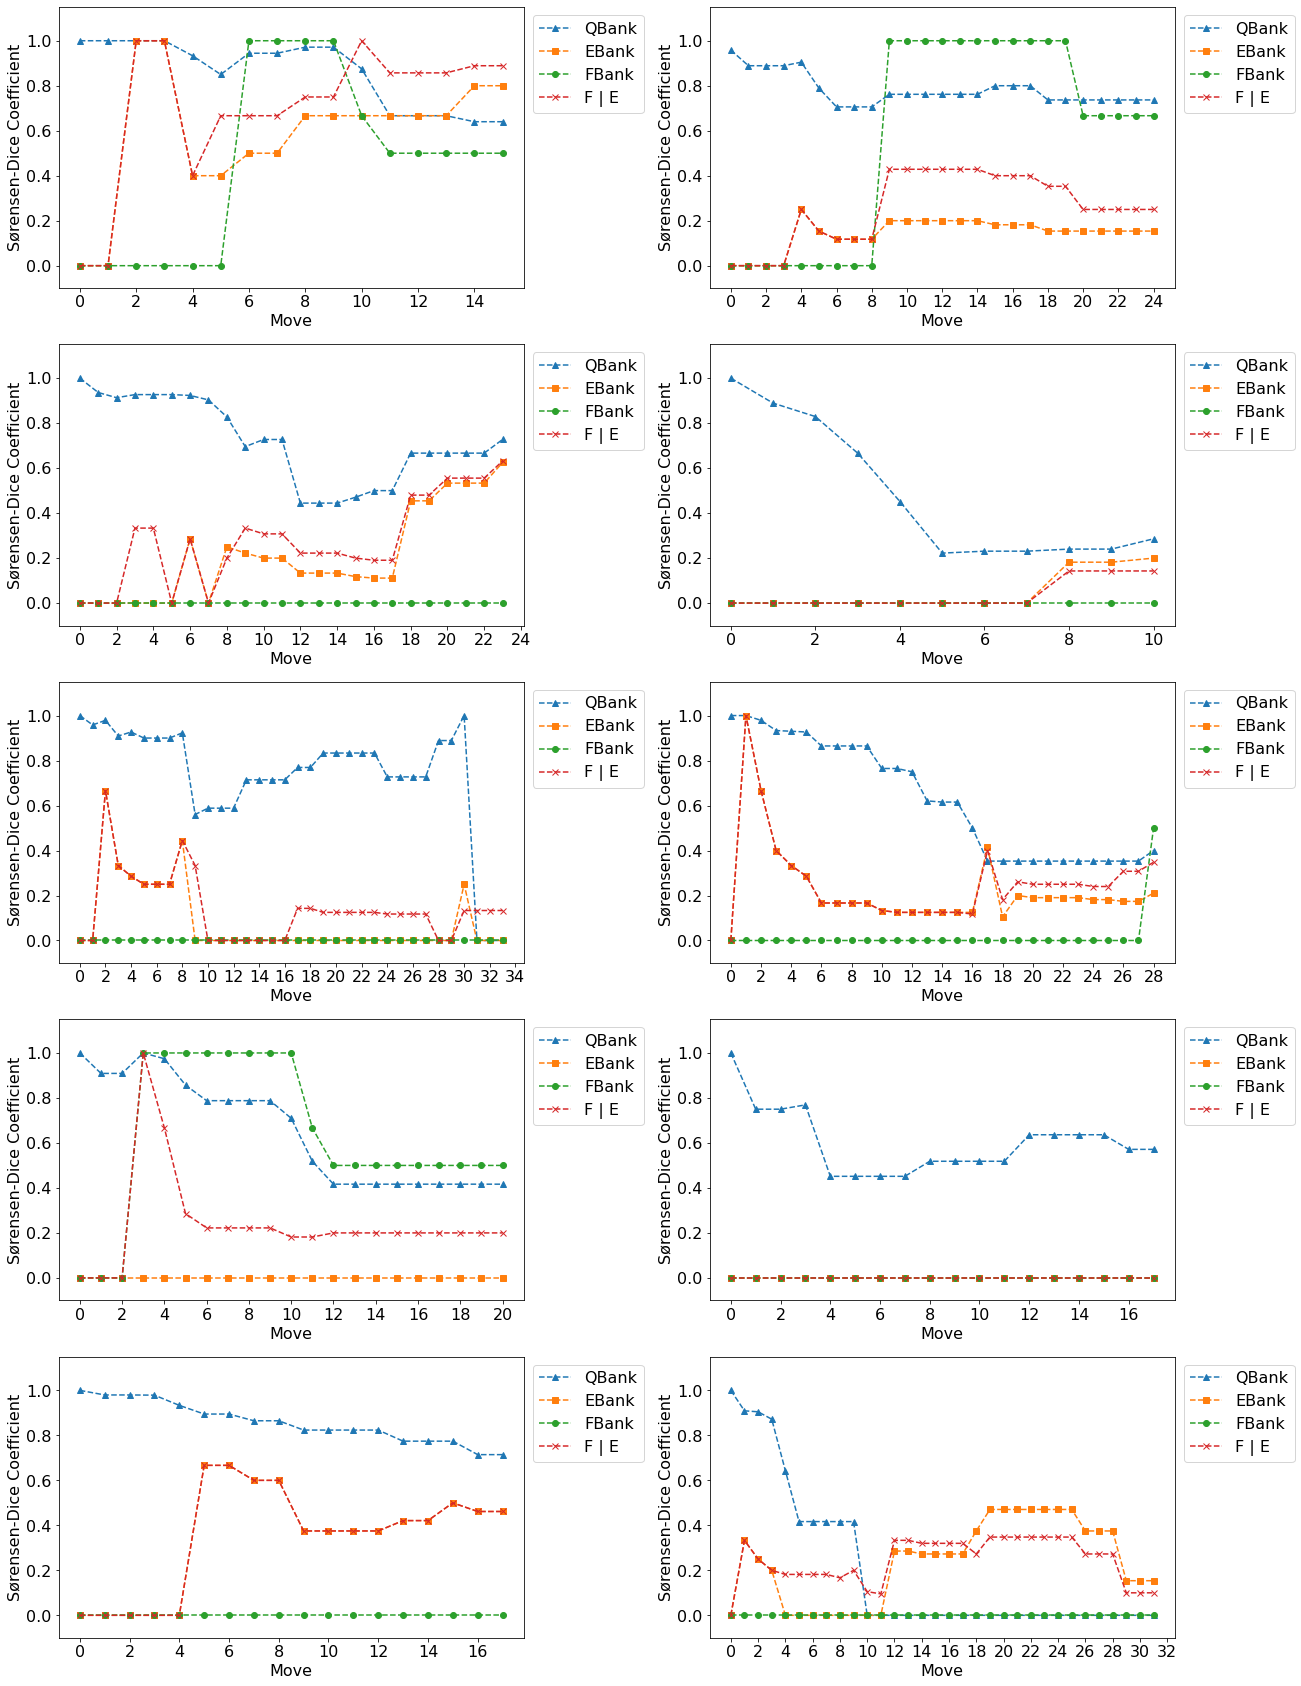

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10
QBank,0.861,0.783,0.721,0.481,0.734,0.626,0.656,0.602,0.858,0.200
EBank,0.587,0.143,0.210,0.051,0.080,0.229,0.000,0.000,0.350,0.241
FBank,0.448,0.573,0.000,0.000,0.000,0.017,0.627,0.000,0.000,0.000
F | E,0.703,0.259,0.275,0.039,0.139,0.259,0.238,0.000,0.350,0.245


\begin{table*}[htb]
    \resizebox{\textwidth}{!}{
    \begin{tabular}{lllllllllll}
\toprule
 & {\bf Group 1} & {\bf Group 2} & {\bf Group 3} & {\bf Group 4} & {\bf Group 5} & {\bf Group 6} & {\bf Group 7} & {\bf Group 8} & {\bf Group 9} & {\bf Group 10} \\
\midrule
{\bf QBank} & 0.861 & 0.783 & 0.721 & 0.481 & 0.734 & 0.626 & 0.656 & 0.602 & 0.858 & 0.200 \\
{\bf EBank} & 0.587 & 0.143 & 0.210 & 0.051 & 0.080 & 0.229 & 0.000 & 0.000 & 0.350 & 0.241 \\
{\bf FBank} & 0.448 & 0.573 & 0.000 & 0.000 & 0.000 & 0.017 & 0.627 & 0.000 & 0.000 & 0.000 \\
{\bf F | E} & 0.703 & 0.259 & 0.275 & 0.039 & 0.139 & 0.259 & 0.238 & 0.000 & 0.350 & 0.245 \\
\bottomrule
	\end{tabular}}
	\label{tab:table}
	\caption{Caption}
\end{table*}


In [495]:
font = {'size' : 16}

plt.rc('font', **font)

labels = ["QBank","EBank","FBank", "F | E"]
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
fig.subplots_adjust(wspace=0.4)

average_traces = []
for test_group in range(0,10):
    row = int(test_group/2)
    col = test_group % 2
    axs[row][col].plot(qtraces[test_group],'^--')
    axs[row][col].plot(etraces[test_group],'s--')
    axs[row][col].plot(ftraces[test_group],'o--')
    axs[row][col].plot(fuetraces[test_group],'x--')
    axs[row][col].set_xlabel('Move')
    axs[row][col].set_ylabel('Sørensen-Dice Coefficient')
    axs[row][col].set_ylim(-.1, 1.15)
    start, end = axs[row][col].get_xlim()
    axs[row][col].xaxis.set_ticks(np.arange(0, end, 2))
    legend = axs[row][col].legend(labels=labels, loc="upper right", fontsize="16", bbox_to_anchor=(1.275, 1.0))
    print(f"Group {test_group+1}")
    print(f"Avg. QBank: {np.mean(qtraces[test_group]):.3f}")
    print(f"Avg. EBank: {np.mean(etraces[test_group]):.3f}")
    print(f"Avg. FBank: {np.mean(ftraces[test_group]):.3f}")
    print(f"Avg. F|E: {np.mean(fuetraces[test_group]):.3f}")
    print()
    average_traces.append([np.mean(qtraces[test_group]),\
                           np.mean(etraces[test_group]),\
                           np.mean(ftraces[test_group]),\
                           np.mean(fuetraces[test_group])])
plt.show()
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5',\
                   'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']
banks = ['QBank', 'EBank', 'FBank', 'F | E']
df = pd.DataFrame(np.swapaxes(average_traces,0,1), columns=groups)
df.index = banks
df = df.round(3)
display(df)
print(f"""\\begin{{table*}}[htb]
    \\resizebox{{\\textwidth}}{{!}}{{
    \\begin{{tabular}}{{{"l"*(len(groups)+1)}}}""")
print("\\toprule")
print(" & " + " & ".join(["{\\bf " + col + "}" for col in df.columns.tolist()]) + " \\\\")
print("\\midrule")
print("{\\bf QBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["QBank"].values.tolist()]) + " \\\\")
print("{\\bf EBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["EBank"].values.tolist()]) + " \\\\")
print("{\\bf FBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["FBank"].values.tolist()]) + " \\\\")
print("{\\bf F | E} & " + " & ".join([f'{v:.03f}' for v in df.loc["F | E"].values.tolist()]) + " \\\\")
print("\\bottomrule")
print("""\t\end{tabular}}
\t\label{tab:table}
\t\caption{Caption}
\end{table*}""")


In [496]:
def make_aggregate_traces(qtraces,etraces,ftrace,fuetrace):
    maxlen = max([len(t) for t in fuetraces])
    pad_qtraces = []
    pad_etraces = []
    pad_ftraces = []
    pad_fuetraces = []

    for qtrace in qtraces:
        pad_qtraces.append(qtrace)
        pad_qtraces[-1] = pad_qtraces[-1] + ([pad_qtraces[-1][-1]] * (maxlen-len(pad_qtraces[-1])))

    for etrace in etraces:
        pad_etraces.append(etrace)
        pad_etraces[-1] = pad_etraces[-1] + ([pad_etraces[-1][-1]] * (maxlen-len(pad_etraces[-1])))

    for ftrace in ftraces:
        pad_ftraces.append(ftrace)
        pad_ftraces[-1] = pad_ftraces[-1] + ([pad_ftraces[-1][-1]] * (maxlen-len(pad_ftraces[-1])))

    for fuetrace in fuetraces:
        pad_fuetraces.append(fuetrace)
        pad_fuetraces[-1] = pad_fuetraces[-1] + ([pad_fuetraces[-1][-1]] * (maxlen-len(pad_fuetraces[-1])))
        
    agg_qtrace = np.mean(np.array(pad_qtraces),axis=0)
    agg_etrace = np.mean(np.array(pad_etraces),axis=0)
    agg_ftrace = np.mean(np.array(pad_ftraces),axis=0)
    agg_fuetrace = np.mean(np.array(pad_fuetraces),axis=0)
    
    return agg_qtrace,agg_etrace,agg_ftrace,agg_fuetrace

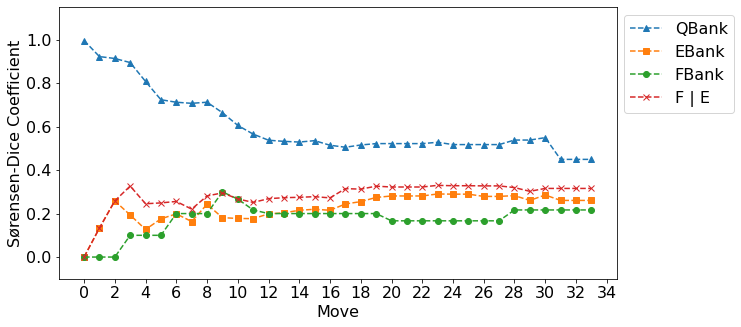

In [497]:
agg_qtrace,agg_etrace,agg_ftrace,agg_fuetrace = make_aggregate_traces(qtraces,etraces,ftraces,fuetraces)
    
font = {'size' : 16}

plt.rc('font', **font)

labels = ["QBank","EBank","FBank", "F | E"]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

ax.plot(agg_qtrace,'^--')
ax.plot(agg_etrace,'s--')
ax.plot(agg_ftrace,'o--')
ax.plot(agg_fuetrace,'x--')
ax.set_xlabel('Move')
ax.set_ylabel('Sørensen-Dice Coefficient')
ax.set_ylim(-.1, 1.15)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 2))
legend = ax.legend(labels=labels, loc="upper right", fontsize="16", bbox_to_anchor=(1.225, 1.0))
plt.show()

/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_01


,Utterance,Start,End,Statement,Accept,Doubt
5,5,24.42,27.72,1,0,0
6,6,29.08,29.83,0,1,0
24,24,78.08,80.58,1,0,0
26,26,80.58,84.30,1,0,0
30,30,95.19,97.17,1,0,0
31,31,97.56,102.03,0,1,0
32,32,102.39,105.87,0,1,0
33,33,104.08,104.58,0,1,0
41,41,127.35,132.00,1,0,0
42,42,128.83,130.08,1,0,0


,START,END,TRUE,PREDICTED
0,24.42,27.72,Statement,Statement
1,29.08,29.83,Accept,Statement
2,78.08,80.58,Statement,Statement
3,80.58,84.30,Statement,Statement
4,95.19,97.17,Statement,Statement
5,97.56,102.03,Accept,Statement
6,102.39,105.87,Accept,Statement
7,104.08,104.58,Accept,Statement
8,127.35,132.00,Statement,Statement
9,128.83,130.08,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,24.420,27.720,S0: STATEMENT(red = 10)
1,28.940,29.470,ACCEPT(S0)
2,80.520,81.670,S1: STATEMENT(red = 10)
5,95.190,97.170,S2: STATEMENT(red = blue)
6,97.577,98.088,ACCEPT(S2)
7,99.780,102.030,S3: STATEMENT(blue = 10)
8,104.080,104.580,ACCEPT(S3)
12,112.420,112.720,S4: STATEMENT(purple > 20)
13,112.740,113.760,S5: STATEMENT: (purple != 20)
16,127.350,129.190,S6: STATEMENT(green = 20)


,Start,End,DPed
0,58.33,58.84,it's right there
1,70.51,70.01,um it's turned off
2,78.08,80.58,ok well red block would be nine minus ten
3,80.58,84.30,red block's ten so then
4,86.07,87.41,just like put it on
5,95.19,97.17,"red block, blue block seems pretty balanced"
6,97.56,102.03,yeah ok so now we know that blue block is also...
7,106.23,110.01,what would we maybe put blue block one on ther...
8,112.16,112.92,purple block's more
9,114.87,120.33,lets try yellow block one oh gee louise green ...


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'blue=10', 'S4': 'purple>20', 'S5': 'purple!=20', 'S6': 'green=20', 'S7': 'red=10,blue=10,green=20', 'S9': 'purple=30', 'S10': 'yellow>purple+red+blue', 'S11': 'red=10,blue=10,green=20,purple=30', 'S12': 'yellow<50', 'S13': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.

0.8375101 red block equals ten
DP Content: red=10
S1: replacing red=10 with red=10
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: {'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 

0.75690615 green block equals twenty
DP Content: green=20
S7: replacing red=10,blue=10,green=20 with green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=40', 'green=30', 'yellow=50', 'yellow=30', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'yellow=10', 'purple=10', 'red=40', 'purple=20', 'red=20', 'red=50', 'purple=50', 'purple=30', 'red=30'}
self.ebank: {'green=20', 'red=10'}
self.fbank: {'blue=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': s

0.85888624 blue block is more than green block plus purple block
DP Content: blue>green+purple
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'yellow=10', 'red=40', 'red=20', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'green=20', 'red=10'}
self.fbank: {'blue=10', 'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': {10, 20}, 'gree

,Utterance,Start,End,Statement,Accept,Doubt
5,5,23.52,32.73,1,0,0
20,20,88.98,91.58,1,0,0
25,25,104.08,106.23,1,0,0
26,26,102.45,104.75,1,0,0
33,33,124.68,127.02,1,0,0
37,37,141.27,146.91,1,0,0
38,38,144.92,149.08,1,0,0
39,39,149.97,151.95,0,1,0
40,40,152.31,153.75,1,0,0
41,41,154.58,155.34,0,1,0


,START,END,TRUE,PREDICTED
0,23.52,32.73,Statement,Statement
1,88.98,91.58,Statement,Statement
2,104.08,106.23,Statement,Statement
3,102.45,104.75,Statement,Statement
4,124.68,127.02,Statement,Statement
5,141.27,146.91,Statement,Statement
6,144.92,149.08,Statement,Statement
7,149.97,151.95,Accept,Statement
8,152.31,153.75,Statement,Statement
9,154.58,155.34,Accept,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,23.52,26.76,S0: STATEMENT(red =10)
1,88.98,91.58,S1: STATEMENT(red = blue)
2,104.08,106.23,S2: STATEMENT(blue = 10)
4,124.68,127.02,S4: STATEMENT(green = red + blue)
5,144.92,149.08,S5: STATEMENT(green = 20)
6,149.97,151.95,ACCEPT(S4)
7,152.31,153.75,S6: STATEMENT(red = 10 and blue = 10)
8,154.58,155.34,ACCEPT(S6)
9,158.13,164.17,S7: STATEMENT(green = 20)
10,165.56,166.59,ACCEPT(S7)


,Start,End,DPed
0,27.15,28.38,can we use this piece of paper
1,81.33,85.53,yeah it's like a bit slow to level up
2,86.82,88.95,so i would imagine if this
3,88.98,91.58,needle goes over the red line that means red b...
4,92.58,94.65,"and i i think red block, blue block are"
5,94.77,97.05,especially since it keeps going back in a
6,97.11,102.39,"yeah red block, blue block also just look like..."
7,104.08,106.23,so blue block one is probably ten grams too
8,108.06,111.30,and then if blue block's ten grams then we hav...
9,112.29,117.87,so i'm going to hold back on yellow block one ...


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'blue=10', 'S4': 'green=red+blue', 'S5': 'green=20', 'S6': 'red=10,blue=10', 'S7': 'green=20', 'S8': 'purple=30', 'S9': 'purple=30', 'S10': 'yellow>purple', 'S12': 'green=20,purple=30', 'S13': 'yellow<green+purple', 'S14': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED

0.84553325 blue block equals twenty
DP Content: blue=20
S2: replacing blue=20 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red':

0.7339152 purple block is more than blue block plus green block
DP Content: purple>blue+green
S7: replacing green=20 with purple>blue+green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green!=10', 'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': 

0.7731513 blue block is more than twenty
DP Content: blue>20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green!=10', 'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': 

0.8616646 red block equals twenty and green block equals forty and purple block equals twenty
DP Content: red=20,green=40,purple=20
S12: replacing green=20,purple=30 with red=20,green=40,purple=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {10}, 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=50', 'purple=10', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'green!=10', 'green=20', 'red=10', 'blue=10', 'purple=30'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10,

/Users/nikhil/Documents/Dev/trunk/Common-Ground-detection/data/Group_03


,Utterance,Start,End,Statement,Accept,Doubt
2,2,33.39,38.04,1,0,0
23,23,144.50,147.27,1,0,0
24,24,142.38,145.07,1,0,0
41,41,214.42,219.93,0,1,0
42,42,212.13,214.16,1,0,0
44,44,219.91,224.42,0,1,0
48,48,238.47,240.45,1,0,0
49,49,241.80,243.42,0,1,0
58,58,269.35,272.58,1,0,0
59,59,274.95,277.05,0,1,0


,START,END,TRUE,PREDICTED
0,33.39,38.04,Statement,Statement
1,144.50,147.27,Statement,Statement
2,142.38,145.07,Statement,Statement
3,214.42,219.93,Accept,Statement
4,212.13,214.16,Statement,Statement
5,219.91,224.42,Accept,Statement
6,238.47,240.45,Statement,Statement
7,241.80,243.42,Accept,Statement
8,269.35,272.58,Statement,Statement
9,274.95,277.05,Accept,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,33.39,38.04,S0: STATEMENT(red = 10)
3,142.38,145.07,S1: STATEMENT(red = blue)
4,145.10,147.27,ACCEPT(S1)
7,212.13,214.16,S2: STATEMENT(green = 20)
8,214.42,219.93,ACCEPT(S2)
10,238.47,240.45,S3: STATEMENT(purple = 30)
11,241.80,243.42,ACCEPT(S3)
13,269.35,272.58,S4: STATEMENT(green = 20 and purple = 30 and y...
14,274.95,277.05,ACCEPT(S4)
15,277.53,279.75,S5: STATEMENT(green = 20)


,Start,End,DPed
0,86.43,87.67,prepare things for red block one
1,112.41,114.39,"so you think red block, blue block're the same..."
2,116.13,118.17,"red block, blue block're still teetering"
3,144.50,147.27,"i think red block, blue block're the same weig..."
4,142.38,145.07,"i think red block, blue block are same weight"
5,162.40,165.36,the blue one is also ten right
6,165.45,167.82,so i should indicate blue block as ten
7,186.96,192.42,the suspense is killing me it takes forever
8,214.42,219.93,yes green block's probably twenty so green one...
9,212.13,214.16,sufficient to say green block one's probably t...


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'green=20', 'S3': 'purple=30', 'S4': 'green=20,purple=30,yellow=50', 'S5': 'green=20', 'S6': 'yellow<green+purple', 'S7': 'yellow!=10', 'S8': 'yellow>green+blue+red', 'S9': 'yellow=50', 'S10': 'yellow!=30', 'S11': 'yellow=50', 'S12': 'purple=30,yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
s

0.79363126 green block equals twenty
DP Content: green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'blue=20', 'yellow=20', 'purple=10', 'red=10', 'purple=30', 'red=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: {'green=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {

0.8534609 purple block equals forty
DP Content: purple=40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'yellow=50', 'blue=20', 'yellow=20', 'yellow=40', 'yellow=10', 'blue=50', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'yellow=30', 'blue=10', 'red=30'}
self.ebank: set()
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': {40, 30}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), 'green': {10, 20, 30}, 'purple': set(), 'yellow'

0.7129372 purple block is more than fifty
DP Content: purple>50
S5: replacing green=40 with purple>50
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'yellow=20', 'yellow=40', 'yellow=10', 'red=40', 'red=10', 'red=20', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'green=20', 'yellow=50'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {40, 20}, 'green': {20}, 'purple': {40, 30}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), 'green': {10, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'y

0.87923 purple block equals green block
DP Content: purple=green
S8: replacing blue=20 with purple=green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.qbank: {'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=50', 'green=20', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {40, 20}, 'green': {40, 20, 30}, 'purple': {40, 30}, 'yellow': set()}
self.evidence_against: {'red': {10}, 'blue': set(), 'green': {40,

Summed embeddings shape is: 22 x 768
0.9240141 green block is more than red block plus blue block plus purple block plus yellow block
DP Content: green>red+blue+purple+yellow
S11: replacing green>red+blue+purple+yellow with green>red+blue+purple+yellow
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 50, 20, 30}}
self.qbank: {'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=50', 'green=20', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': se

,Utterance,Start,End,Statement,Accept,Doubt
8,8,33.30,36.24,1,0,0
19,19,83.58,83.84,0,0,1
22,22,91.67,95.35,1,0,0
32,32,123.50,127.41,1,0,0
33,33,124.15,125.03,0,0,1
36,36,130.65,132.50,0,1,0
45,45,157.84,159.83,1,0,0
46,46,160.63,161.79,0,0,1
47,47,161.88,162.59,1,0,0
48,48,162.59,163.86,1,0,0


,START,END,TRUE,PREDICTED
0,33.30,36.24,Statement,Statement
1,83.58,83.84,Doubt,Statement
2,91.67,95.35,Statement,Statement
3,123.50,127.41,Statement,Statement
4,124.15,125.03,Doubt,Statement
5,130.65,132.50,Accept,Statement
6,157.84,159.83,Statement,Statement
7,160.63,161.79,Doubt,Statement
8,161.88,162.59,Statement,Statement
9,162.59,163.86,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,33.30,36.23,S0: STATEMENT(red = 10)
5,81.61,82.96,S1: STATEMENT(blue = 10)
6,83.57,84.38,DOUBT(S1)
8,91.14,91.75,S2: STATEMENT(green = 20)
18,121.58,123.64,S3: STATEMENT(purple = 30)
19,123.65,124.43,DOUBT(S3)
21,125.49,127.16,S4: STATEMENT(purple != 40)
23,127.96,129.29,S5: STATEMENT(purple != 20)
24,129.51,130.62,S6: STATEMENT(purple = 30)
25,130.65,131.94,ACCEPT(S6)


,Start,End,DPed
0,21.50,22.25,that was awkward
1,66.41,70.80,"uh red block, blue block, green block, purple ..."
2,64.90,67.66,ok so the red has ten
3,72.21,80.64,well then no let's compare the red to the blue...
4,83.58,83.84,is it
5,85.12,86.13,once it stops
6,89.82,97.32,ok there easy so green block is twenty yeah ca...
7,91.67,95.35,is blue block ten and green block was equal to...
8,97.83,99.96,and then green block was
9,106.05,110.84,i feel like purple block one is oh yeah so thi...


{'S0': 'red=10', 'S1': 'blue=10', 'S2': 'green=20', 'S3': 'purple=30', 'S4': 'purple!=40', 'S5': 'purple!=20', 'S6': 'purple=30', 'S7': 'yellow=50', 'S8': 'blue=10', 'S9': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 5

0.8412982 blue block is more than forty
DP Content: blue>40
S4: replacing purple!=40 with blue>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40}, 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: {'purple!=40', 'green=20'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for:

0.759323 green block is more than blue block plus purple block
DP Content: green>blue+purple
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'yellow=10', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'yellow=30', 'blue=10', 'red=30'}
self.ebank: {'green=20', 'yellow=50'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {20}, 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40}}
s

,Utterance,Start,End,Statement,Accept,Doubt
3,3,20.25,22.68,1,0,0
14,14,60.08,64.08,1,0,0
15,15,62.91,64.62,1,0,0
24,24,92.25,95.19,1,0,0
25,25,95.79,99.00,0,1,0
28,28,108.33,112.17,1,0,0
29,29,108.58,112.17,1,0,0
30,30,112.62,113.02,0,1,0
34,34,131.62,132.99,1,0,0
35,35,133.33,136.65,0,1,0


,START,END,TRUE,PREDICTED
0,20.25,22.68,Statement,Statement
1,60.08,64.08,Statement,Statement
2,62.91,64.62,Statement,Statement
3,92.25,95.19,Statement,Statement
4,95.79,99.00,Accept,Statement
5,108.33,112.17,Statement,Statement
6,108.58,112.17,Statement,Statement
7,112.62,113.02,Accept,Statement
8,131.62,132.99,Statement,Statement
9,133.33,136.65,Accept,Doubt


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,20.24,22.70,S0: STATEMENT(red = 10)
1,62.91,64.62,S1: STATEMENT(red = 10)
3,92.25,95.19,S2: STATEMENT(red = blue)
4,95.79,99.00,ACCEPT(S2)
5,108.58,112.17,S3: STATEMENT(red = 10 and blue = 10)
6,112.62,113.02,ACCEPT(S3)
7,131.62,132.99,S4: STATEMENT(green = 20)
8,133.23,134.17,ACCEPT(S4)
9,134.19,136.63,S5: STATEMENT(red = 10 and blue = 10 and green...
10,147.96,154.32,S6: STATEMENT(green = 20)


,Start,End,DPed
0,23.58,24.25,can we write that down
1,60.08,64.08,alright reese you can fill out the survey on t...
2,62.91,64.62,so we know red block is ten
3,65.43,74.13,so you hold that at the end of the scale yeah ...
4,68.88,74.02,so we know red block is ten set red block ther...
5,74.96,84.46,what's green block one ok so ok so we know tha...
6,77.25,85.57,green block's heavy yep
7,85.25,86.12,so we could put blue block there
8,92.25,95.19,"i'd say red block, blue block's basically the ..."
9,95.79,99.00,yeah if that's what we're going off of


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'red=10,blue=10', 'S4': 'green=20', 'S5': 'red=10,blue=10,green=20', 'S6': 'green=20', 'S7': 'purple>green', 'S8': 'purple>20', 'S9': 'purple=30', 'S10': 'purple=30,green=20', 'S11': 'yellow=50', 'S12': 'yellow=50', 'S13': 'yellow=50,purple=30', 'S14': 'purple=30'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue

0.8214598 purple block is more than red block plus green block
DP Content: purple>red+green
S2: replacing red=blue with purple>red+green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {4

0.8388386 green block equals twenty
DP Content: green=20
S4: replacing green=20 with green=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {40}, 'green': {2

0.73545265 green block equals twenty
DP Content: green=20
S6: replacing green=20 with green=20
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'yellow=30', 'yellow=20', 'yellow=40', 'yellow=10', 'purple=50', 'purple=30'}
self.ebank: set()
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10, 20}, 'blue': {40}, 'green': {40, 20}, 'purple': {50, 10}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {10, 20}, 'yellow': set()}
self.qbank: {'purple=40'

0.83987564 purple block is less than fifty
DP Content: purple<50
S8: replacing purple=20 with purple<50
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=50', 'yellow=20', 'yellow=10', 'yellow=40', 'yellow=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10, 20}, 'blue': {40}, 'green': {40, 20}, 'purple': {50, 10, 20}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple

0.7611616 blue block is less than forty
DP Content: blue<40
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=50', 'yellow=20', 'yellow=10', 'yellow=40', 'yellow=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 10, 20}, 'blue': {40, 10}, 'green': {40, 10, 20}, 'purple': {50, 10, 20}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': {40, 50}, 'green': set(), 'purple': {10, 20, 50}, 

0.7744594 green block is more than blue block plus purple block
DP Content: green>blue+purple
S11: replacing yellow=50 with green>blue+purple
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 10, 20}, 'blue': {40, 10}, 'green': {40, 10, 20}, 'purple': {50, 10, 20}, 'yellow': set()}
self.evidence_a

Summed embeddings shape is: 12 x 768
0.7867235 blue block equals twenty
DP Content: blue=20
S12: replacing red=10,blue=40,green=40 with blue=20
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 10, 20}, 'blue': {40, 10, 20}, 'green': {40, 10, 20}, 'purple': {50, 10, 20}, 'yellow': set()}
self.evid

0.77482116 purple block equals twenty
DP Content: purple=20
S14: replacing purple=30 with purple=20
TRUE:
self.poss: {'red': {40}, 'blue': {10}, 'green': {10}, 'purple': {40, 50, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40}, 'blue': {10, 20}, 'green': {10}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'red=40', 'green=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 10, 20, 30}, 'blue': {40, 10, 20}, 'green': {40, 10, 20}, 'purple': {40, 50, 10, 20}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blu

,Utterance,Start,End,Statement,Accept,Doubt
3,3,21.12,24.51,1,0,0
9,9,61.23,64.67,1,0,0
10,10,63.42,66.00,1,0,0
12,12,72.45,76.17,1,0,0
13,13,80.52,85.29,0,1,0
15,15,89.76,91.06,1,0,0
19,19,102.35,104.28,1,0,0
20,20,102.30,103.50,1,0,0
25,25,119.42,121.75,1,0,0
26,26,116.79,125.37,1,0,0


,START,END,TRUE,PREDICTED
0,21.12,24.51,Statement,Accept
1,61.23,64.67,Statement,Accept
2,63.42,66.00,Statement,Accept
3,72.45,76.17,Statement,Doubt
4,80.52,85.29,Accept,Doubt
5,89.76,91.06,Statement,Accept
6,102.35,104.28,Statement,Statement
7,102.30,103.50,Statement,Doubt
8,119.42,121.75,Statement,Accept
9,116.79,125.37,Statement,Accept


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,21.12,24.51,S0: STATEMENT(red = 10)
1,63.42,66.00,S1: STATEMENT(red = 10)
2,72.45,76.17,S2: STATEMENT(red = blue)
3,80.52,85.29,ACCEPT(S2)
5,89.76,91.06,S3: STATEMENT(purple > red + blue)
6,102.35,104.28,S4: STATEMENT(green = 20)
8,116.79,125.37,S5: STATEMENT(red = 10 and green = 20)
10,141.18,146.85,S6: STATEMENT(purple > 20 and purple < 30)
11,156.33,161.08,S7: STATEMENT(purple = 30)
12,164.46,166.67,ACCEPT(S7)


,Start,End,DPed
0,61.23,64.67,i guess if red block red one's ten grams
1,63.42,66.00,we got red ten
2,72.45,76.17,"seems like red block, blue block might be abou..."
3,80.52,85.29,i would agree yeah so blue block one's ten
4,97.44,99.78,this is a sensitive scale
5,102.30,103.50,that's looking pretty even
6,110.82,113.19,so yellow block one is noticeably heavier than
7,109.44,110.75,probably yellow block big sucker
8,113.94,115.95,the purple ish one
9,119.42,121.75,making sure that purple block didn't have the ...


{'S0': 'red=10', 'S1': 'red=10', 'S2': 'red=blue', 'S3': 'purple>red+blue', 'S4': 'green=20', 'S5': 'red=10,green=20', 'S6': 'purple>20,purple<30', 'S7': 'purple=30', 'S8': 'yellow=50', 'S9': 'yellow<50', 'S10': 'purple=30,green=20', 'S11': 'red=10,blue=10', 'S12': 'yellow<purple+green', 'S13': 'purple+green=50', 'S14': 'purple+blue=40', 'S15': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'p

Summed embeddings shape is: 9 x 768
0.8515955 purple block is more than red block
DP Content: purple>red
S2: replacing red=blue with purple>red
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50

DP Content: blue>40
S4: replacing blue>40 with blue>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {10, 20}, 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'red=20', 'blue=40'}
self.ebank: {'purple!=20', 'green=20', 'purple!=10', 'red=10', 'blue=10'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {20}, 'blue': set(), 'green': set(), 'purple': set(), 'yellow':

Summed embeddings shape is: 24 x 768
0.88406205 purple block equals red block plus blue block plus green block
DP Content: purple=red+blue+green
S7: replacing purple=30 with purple=red+blue+green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'yellow=10', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'blue=10', 'purple!=40', 'purple=30'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': set(), 'green': {40, 10, 50

Summed embeddings shape is: 17 x 768
0.8622554 green block is more than red block plus blue block plus purple block
DP Content: green>red+blue+purple
S9: replacing yellow<50 with green>red+blue+purple
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': set(), '

Summed embeddings shape is: 8 x 768
0.8823061 purple block equals green block
DP Content: purple=green
S13: replacing purple+green=50 with purple=green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': set(), 'green': {20}, 'purple': {20}, 'yellow': {50}}
sel

Summed embeddings shape is: 5 x 768
0.8196016 blue block equals forty
DP Content: blue=40
S14: replacing red=20,blue=40,purple=10 with blue=40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 50, 20, 30}, 'yellow': {40, 50, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50, 10, 20}}
self.qbank: {'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'yellow=40', 'blue=50', 'red=40', 'blue=30', 'red=20', 'blue=40', 'red=50', 'yellow=30', 'red=30'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'green=20', 'purple!=10', 'red=10', 'yellow!=10', 'blue=10', 'purple!=40', 'purple=30', 'yellow!=20'}
self.fbank: set()
PRED:
self.poss: {'red': {20}, 'blue': set(), 'green': {20}, 'purple': {20}, 'yellow': {50}}
self.evidenc

,Utterance,Start,End,Statement,Accept,Doubt
5,5,30.90,33.50,1,0,0
6,6,34.59,37.83,1,0,0
20,20,107.08,107.34,1,0,0
21,21,107.31,109.09,1,0,0
22,22,110.32,111.14,0,1,0
...,...,...,...,...,...,...
171,171,500.25,500.75,1,0,0
172,172,513.63,517.17,1,0,0
173,173,517.67,520.41,1,0,0
174,174,520.91,521.42,1,0,0


,START,END,TRUE,PREDICTED
0,30.90,33.50,Statement,Doubt
1,34.59,37.83,Statement,Doubt
2,107.08,107.34,Statement,Accept
3,107.31,109.09,Statement,Accept
4,110.32,111.14,Accept,Doubt
...,...,...,...,...
58,500.25,500.75,Statement,Doubt
59,513.63,517.17,Statement,Doubt
60,517.67,520.41,Statement,Doubt
61,520.91,521.42,Statement,Doubt


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,30.90,34.59,S0: STATEMENT(red = 10)
1,107.31,109.09,S1: STATEMENT(blue = 10)
2,110.32,111.14,ACCEPT(S1)
3,139.87,142.15,S2: STATEMENT(green = 20)
6,152.57,153.59,S3: STATEMENT(green + red + blue = 40)
7,179.32,181.84,S4: STATEMENT(purple = 30)
8,192.91,194.92,S5: STATEMENT(green = 20 and purple = 30)
9,212.92,213.95,S6: STATEMENT(yellow = 50)
10,226.50,228.62,ACCEPT(S6)
11,243.00,246.17,DOUBT(S6)


,Start,End,DPed
0,98.50,101.75,i think so as well or i think it's the other w...
1,107.31,109.09,blue block seems to be ten
2,112.42,114.67,is blue block blue or purple blue block is blu...
3,114.41,115.17,blue block is blue
4,116.42,118.12,and red block was ten
...,...,...,...
58,457.21,458.84,no okay i think yellow block's fifty
59,469.42,476.25,yeah i think so so red ten yeah
60,470.13,477.00,that is correct yellow is fifty purple was thi...
61,491.91,492.67,green was


{'S0': 'red=10', 'S1': 'blue=10', 'S2': 'green=20', 'S3': 'green+red+blue=40', 'S4': 'purple=30', 'S5': 'green=20,purple=30', 'S6': 'yellow=50', 'S7': 'yellow=50', 'S8': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50,

0.8674062 red block equals green block
DP Content: red=green
S2: replacing green=20 with red=green
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green=20'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 

0.8133815 purple block equals fifty
DP Content: purple=50
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'red=30', 'green=30', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'blue=10', 'green=20', 'yellow=50', 'purple=30'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': set(), 'purple': {50

0.8132653 blue block equals twenty
DP Content: blue=20
S7: replacing yellow=50 with blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.evidence_for: {'red': set(), 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'green=40', 'green=30', 'blue=20', 'green=10', 'green=50', 'blue=50', 'purple=10', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'purple=20', 'purple=50', 'red=30'}
self.ebank: {'blue=10', 'green=20', 'purple=30'}
self.fbank: {'yellow=50'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': set(), 'purple': {50, 20}, 'yellow': set()}
self.evidence_a

,Utterance,Start,End,Statement,Accept,Doubt
3,3,13.08,15.21,0,1,0
14,14,48.78,51.75,0,1,0
15,15,45.75,50.01,0,1,0
23,23,74.12,74.75,1,0,0
46,46,155.40,157.66,1,0,0
47,47,157.58,159.33,1,0,0
54,54,168.21,170.67,1,0,0
63,63,194.46,196.62,1,0,0
64,64,198.15,203.75,0,0,1
65,65,197.10,198.92,0,0,1


,START,END,TRUE,PREDICTED
0,13.08,15.21,Accept,Statement
1,48.78,51.75,Accept,Statement
2,45.75,50.01,Accept,Statement
3,74.12,74.75,Statement,Statement
4,155.40,157.66,Statement,Statement
5,157.58,159.33,Statement,Statement
6,168.21,170.67,Statement,Statement
7,194.46,196.62,Statement,Statement
8,198.15,203.75,Doubt,Statement
9,197.10,198.92,Doubt,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
2,10.090,11.430,S1: STATEMENT(green = 20)
3,13.290,14.040,ACCEPT(S1)
7,33.940,35.650,S2: STATEMENT(purple = 30)
8,48.780,51.750,ACCEPT(S2)
12,74.080,76.060,S3: STATEMENT(yellow < purple + green)
16,133.433,134.777,S4: STATEMENT(yellow > 40)
18,144.780,146.770,S5: STATEMENT(40 < yellow < 50)
19,157.580,159.330,S6: STATEMENT(yellow > 40)
22,168.190,170.670,S7: STATEMENT (40 < yellow > 50)
25,194.450,196.620,S8: STATEMENT(yellow < 50)


,Start,End,DPed
0,5.97,8.04,or is green block
1,8.07,11.55,yeah green is for twenty
2,15.45,18.21,"i'll just take red block, blue block off and t..."
3,22.65,24.63,it's ok
4,25.74,29.02,can i add the red one or blue one here maybe p...
5,32.52,35.67,so twenty purple block's thirty
6,42.60,47.75,i mean the fact that it's teetering back and f...
7,45.45,48.72,yeah so the blue one is thirty
8,48.78,51.75,blue is thirty big blue is thirty
9,51.87,54.33,so purple block's thirty here


{'S1': 'green=20', 'S2': 'purple=30', 'S3': 'yellow<purple+green', 'S4': 'yellow>40', 'S5': '40<yellow<50', 'S6': 'yellow>40', 'S7': '40<yellow>50', 'S8': 'yellow<50', 'S9': 'yellow=41', 'S10': 'yellow=49', 'S11': 'yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue':

0.6313252 red block is more than forty
DP Content: red>40
S6: replacing yellow>40 with red>40
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'green=10', 'green=50', 'blue=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'blue=10', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {30}, 'green': set(), 'purple': {40}, 

0.8407716 blue block equals twenty
DP Content: blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'green=10', 'green=50', 'blue=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'blue=10', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20, 30}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_agai

0.84619474 blue block equals thirty
DP Content: blue=30
S10: replacing yellow=49 with blue=30
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'yellow=50', 'blue=20', 'green=10', 'green=50', 'blue=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'blue=40', 'blue=30', 'blue=10', 'red=30'}
self.ebank: {'yellow!=40', 'yellow!=10', 'yellow!=30', 'yellow!=20'}
self.fbank: {'purple=30'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20, 30}, 'green': set(), 'purple': {4

0.6711452 blue block equals twenty
DP Content: blue=20
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {20}, 'green': {40, 10, 50, 20, 30}, 'purple': {30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20}, 'green': set(), 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': {40, 10, 20, 30}}
self.qbank: {'green=40', 'green=30', 'green=10', 'green=50', 'green=20', 'red=40', 'red=10', 'red=20', 'red=50', 'red=30'}
self.ebank: {'yellow!=40', 'yellow=50', 'yellow!=30', 'yellow!=10', 'yellow!=20'}
self.fbank: {'purple=30', 'blue=20'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': {20, 30}, 'green': set(), 'purple': {40}, 'yellow': set()}
self.evidence_against: {'red': {40, 10, 20, 30}, 'blue': {40, 10, 50, 20, 30}, '

,Utterance,Start,End,Statement,Accept,Doubt
3,3,22.14,24.27,1,0,0
12,12,61.74,63.40,1,0,0
13,13,63.51,65.73,0,1,0
16,16,77.85,79.58,0,1,0
17,17,78.25,79.01,0,1,0
21,21,96.66,97.83,1,0,0
23,23,103.33,105.99,1,0,0
24,24,107.83,108.58,1,0,0
25,25,108.23,111.27,1,0,0
31,31,130.26,133.35,1,0,0


,START,END,TRUE,PREDICTED
0,22.14,24.27,Statement,Statement
1,61.74,63.40,Statement,Statement
2,63.51,65.73,Accept,Statement
3,77.85,79.58,Accept,Statement
4,78.25,79.01,Accept,Statement
5,96.66,97.83,Statement,Statement
6,103.33,105.99,Statement,Accept
7,107.83,108.58,Statement,Statement
8,108.23,111.27,Statement,Statement
9,130.26,133.35,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,22.14,24.27,S0: STATEMENT(red = 10)
1,61.74,63.40,S1: STATEMENT(red = blue)
2,63.51,65.73,ACCEPT(S1)
3,77.85,79.58,ACCEPT(S1)
4,96.66,97.83,S2: STATEMENT(green = red + blue)
5,103.33,105.99,S3: STATEMENT(red = 10 and blue = 10)
6,108.23,111.27,S4: STATEMENT(green != purple)
7,130.26,133.35,S5: STATEMENT(green = 20 and blue = 10)
8,133.38,135.67,S6: STATEMENT(purple = 30)
9,135.71,136.79,ACCEPT(S6)


,Start,End,DPed
0,61.74,63.40,"i would say red block, blue block's equal prob..."
1,77.08,77.75,"i would say red block, blue block's equal"
2,77.85,79.58,yeah blue block should be same i guess
3,78.25,79.01,yeah that 's good
4,79.83,82.33,yeah ok so green block one will go
5,91.05,93.03,i think it's the
6,96.66,97.83,"yeah red block, blue block, green block's prob..."
7,107.83,108.58,purple block's not
8,130.26,133.35,"green block, blue block was twenty and ten rig..."
9,131.58,132.83,"green block, blue block was twenty ten yep"


{'S0': 'red=10', 'S1': 'red=blue', 'S2': 'green=red+blue', 'S3': 'red=10,blue=10', 'S4': 'green!=purple', 'S5': 'green=20,blue=10', 'S6': 'purple=30', 'S7': 'yellow=purple+green', 'S8': 'purple=30,yellow=50'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'red=20', 'blue=40', 'blue=10'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 

0.8853285 blue block equals yellow block
DP Content: blue=yellow
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'green=20', 'purple=20', 'blue=40'}
self.ebank: set()
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yello

0.8439506 blue block is more than purple block
DP Content: blue>purple
S4: replacing blue>purple with blue>purple
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {40, 10, 20, 30}, 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'blue=20', 'yellow=30', 'yellow=20', 'green=50', 'yellow=40', 'blue=50', 'purple=10', 'yellow=10', 'red=40', 'blue=30', 'blue=40', 'red=50', 'purple=50', 'purple=20', 'purple=30', 'red=30'}
self.ebank: {'green!=30', 'green!=20', 'green!=40', 'green!=10', 'red=10', 'blue=10'}
self.fbank: set()
PRED:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {

0.8903123 purple block is more than red block plus blue block plus green block
DP Content: purple>red+blue+green
S7: replacing yellow=purple+green with purple>red+blue+green
TRUE:
self.poss: {'red': {40, 50, 30}, 'blue': {40, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': {40, 10, 20, 30}, 'purple': set(), 'yellow': {10}}
self.qbank: {'purple=40', 'yellow=50', 'blue=20', 'yellow=30', 'yellow=20', 'green=50', 'yellow=40', 'blue=50', 'purple=10', 'red=40', 'blue=30', 'blue=40', 'red=50', 'purple=50', 'purple=20', 'purple=30', 'red=30'}
self.ebank: {'green!=30', 'green!=20', 'green!=40', 'green!=10', 'green=20', 'red=10', 'blue=10', 'yellow!=10'}
self.fbank: set()
PRED:
self.poss: {'red': {10}, 'blue': {10}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'ye

,Utterance,Start,End,Statement,Accept,Doubt
7,7,24.01,26.75,1,0,0
24,24,79.58,82.08,1,0,0
31,31,96.50,98.00,1,0,0
32,32,100.00,101.08,0,1,0
33,33,100.84,102.85,0,1,0
34,34,104.33,105.32,0,0,1
35,35,104.59,106.59,0,0,1
36,36,108.83,110.92,0,0,1
39,39,117.42,119.17,1,0,0
40,40,117.46,118.87,1,0,0


,START,END,TRUE,PREDICTED
0,24.01,26.75,Statement,Statement
1,79.58,82.08,Statement,Statement
2,96.50,98.00,Statement,Statement
3,100.00,101.08,Accept,Statement
4,100.84,102.85,Accept,Statement
5,104.33,105.32,Doubt,Statement
6,104.59,106.59,Doubt,Statement
7,108.83,110.92,Doubt,Statement
8,117.42,119.17,Statement,Statement
9,117.46,118.87,Statement,Statement


,Begin Time - ss.msec,End Time - ss.msec,Common Ground
0,24.775,26.487,S0: STATEMENT(red = 10)
4,81.080,82.080,S1: STATEMENT(green = 20 and blue = 10 and red...
6,97.000,98.000,S2: STATEMENT(red = blue)
7,100.080,101.080,ACCEPT(S2)
8,101.850,102.850,S3: STATEMENT(green = 20 and red = 10 and blue...
9,104.320,105.320,DOUBT(S3)
10,105.590,106.590,ACCEPT(S3)
11,109.920,110.920,DOUBT(S3)
12,118.170,119.170,S4: STATEMENT(red = blue)
13,127.250,128.250,S5: STATEMENT(purple > green)


,Start,End,DPed
0,55.33,57.08,okay so the red is ten grams?
1,60.67,65.67,let's assume that the bigger ones are
2,66.58,70.00,let's put two yeah red one as well
3,68.25,69.50,we can put red block other one here too
4,79.58,82.08,i guess green block is like twenty and red blo...
...,...,...,...
97,693.27,705.56,is that the pattern or is that you know just u...
98,722.25,726.00,mystery block is eight rb i think mystery bloc...
99,727.00,728.50,yellow block is nine rb so
100,730.00,731.50,oh no they don't have any hints here


{'S0': 'red=10', 'S1': 'green=20,blue=10,red=10', 'S2': 'red=blue', 'S3': 'green=20,red=10,blue=10', 'S4': 'red=blue', 'S5': 'purple>green', 'S6': 'purple=green+red', 'S7': 'purple>green+red', 'S8': 'purple=around30', 'S9': 'purple=30,green=20,yellow=50', 'S10': 'yellow<50', 'S11': 'yellow=50', 'S12': 'yellow<50', 'S13': 'yellow<50', 'S14': 'yellow=50', 'S15': 'purple=30,green=20,red=10,blue=10'}

TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'blue=20', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'red=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=4

0.87362486 red block equals forty and blue block equals twenty and green block equals ten
DP Content: red=40,blue=20,green=10
TRUE:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 50, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': set(), 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'yellow=20', 'green=10', 'green=50', 'purple=10', 'purple=30', 'red=30', 'green=30', 'yellow=50', 'yellow=40', 'yellow=10', 'red=50', 'purple=50', 'yellow=30', 'purple=40', 'red=40', 'blue=30', 'blue=50', 'purple=20', 'red=20', 'blue=40'}
self.ebank: {'green=20', 'red=10'}
self.fbank: set()
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'

0.76033485 green block equals twenty
DP Content: green=20
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': set(), 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'purple=40', 'yellow=50', 'yellow=30', 'yellow=20', 'yellow=40', 'yellow=10', 'purple=10', 'purple=20', 'purple=50', 'purple=30'}
self.ebank: set()
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {20}, 'green': {10, 20}, 'purple': {40, 10}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': {10, 20}, 'green': set(), 'purple': set(), 'yellow': set()}
self.qbank: {'green=40', 'g

0.861336 purple block equals red block plus blue block plus green block
DP Content: purple=red+blue+green
S6: replacing purple=green+red with purple=red+blue+green
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': set()}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=50', 'yellow=20', 'yellow=10', 'yellow=40', 'yellow=30'}
self.ebank: {'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50}, 'blue': {20}, 'green': {10, 20}, 'purple': {40, 10}, 'yellow': set()}


Summed embeddings shape is: 27 x 768
0.8275125 red block equals twenty and blue block equals forty and green block equals ten
DP Content: red=20,blue=40,green=10
S9: replacing purple=30,green=20,yellow=50 with red=20,blue=40,green=10
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': set()}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50, 20

Summed embeddings shape is: 8 x 768
0.8676754 red block equals fifty
DP Content: red=50
S12: replacing yellow<50 with red=50
TRUE:
self.poss: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {10}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=10'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50, 20}, 'blue': {40, 20}, 'green': {10, 20}, 'purple': {40, 10}, 'yellow': set()}
self.evidence_again

Summed embeddings shape is: 7 x 768
0.87320876 blue block equals twenty
DP Content: blue=20
S13: replacing yellow<50 with blue=20
TRUE:
self.poss: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {50}, 'blue': {10}, 'green': {20}, 'purple': {30}, 'yellow': {50}}
self.evidence_against: {'red': set(), 'blue': set(), 'green': set(), 'purple': {40, 10, 50, 20, 30}, 'yellow': {50}}
self.qbank: {'yellow=10', 'yellow=30', 'yellow=20', 'yellow=40'}
self.ebank: {'yellow=50', 'purple!=30', 'yellow!=50', 'purple!=50', 'purple!=20', 'purple!=10', 'purple!=40', 'purple=30'}
self.fbank: {'blue=10', 'green=20', 'red=50'}
PRED:
self.poss: {'red': {40, 10, 50, 20, 30}, 'blue': {40, 10, 50, 20, 30}, 'green': {40, 10, 50, 20, 30}, 'purple': {40, 10, 50, 20, 30}, 'yellow': {40, 10, 50, 20, 30}}
self.evidence_for: {'red': {40, 50, 20}, 'blue': {40, 20}, 'green': {10, 20}, 'purple': {40, 10}, 'yellow': set()}
self.evidence_

Group 1
Avg. QBank: 0.840
Avg. EBank: 0.468
Avg. FBank: 0.000
Avg. F|E: 0.579

Group 2
Avg. QBank: 0.760
Avg. EBank: 0.093
Avg. FBank: 0.000
Avg. F|E: 0.093

Group 3
Avg. QBank: 0.658
Avg. EBank: 0.081
Avg. FBank: 0.000
Avg. F|E: 0.231

Group 4
Avg. QBank: 0.621
Avg. EBank: 0.039
Avg. FBank: 0.000
Avg. F|E: 0.046

Group 5
Avg. QBank: 0.635
Avg. EBank: 0.233
Avg. FBank: 0.000
Avg. F|E: 0.394

Group 6
Avg. QBank: 0.341
Avg. EBank: 0.000
Avg. FBank: 0.014
Avg. F|E: 0.173

Group 7
Avg. QBank: 0.756
Avg. EBank: 0.000
Avg. FBank: 0.000
Avg. F|E: 0.000

Group 8
Avg. QBank: 0.615
Avg. EBank: 0.000
Avg. FBank: 0.000
Avg. F|E: 0.005

Group 9
Avg. QBank: 0.633
Avg. EBank: 0.328
Avg. FBank: 0.000
Avg. F|E: 0.442

Group 10
Avg. QBank: 0.426
Avg. EBank: 0.136
Avg. FBank: 0.000
Avg. F|E: 0.228



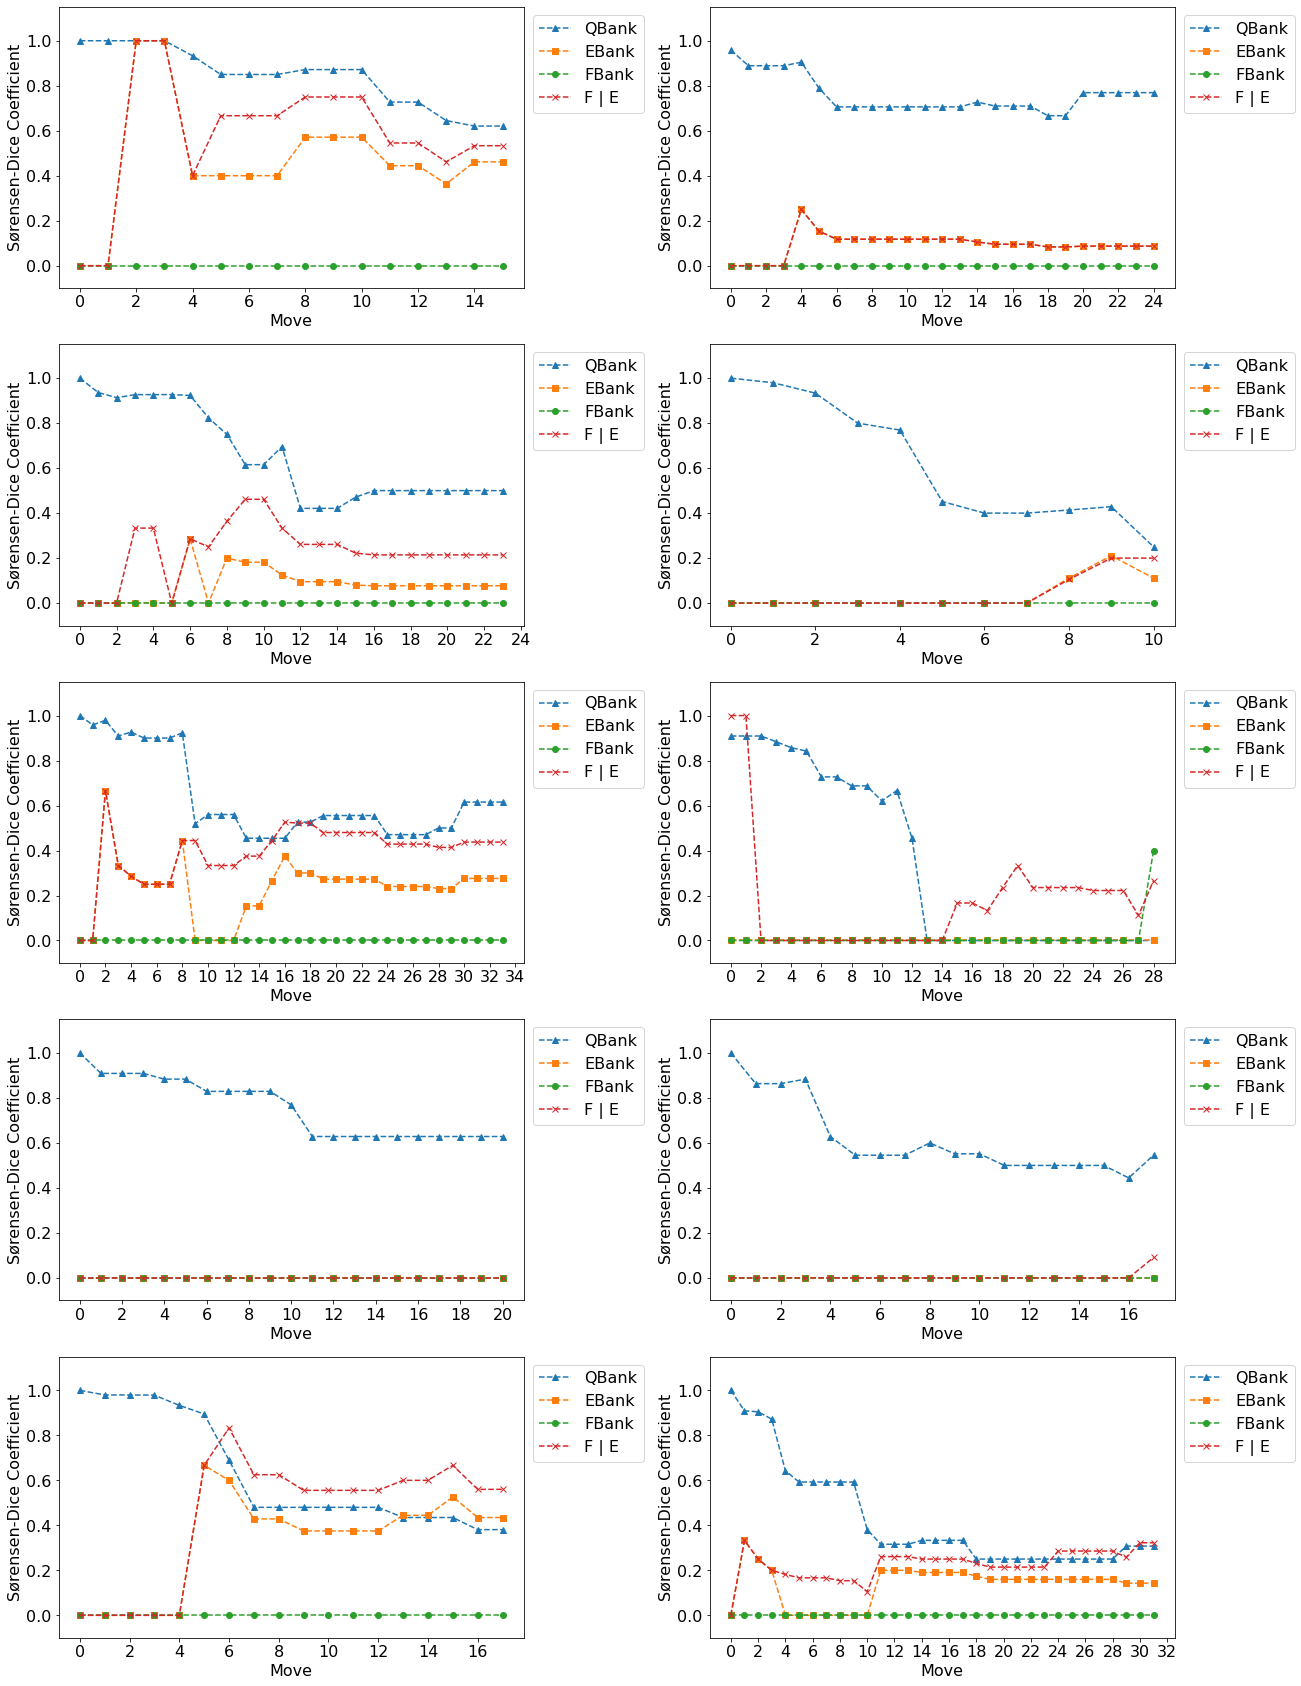

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10
QBank,0.840,0.760,0.658,0.621,0.635,0.341,0.756,0.615,0.633,0.426
EBank,0.468,0.093,0.081,0.039,0.233,0.000,0.000,0.000,0.328,0.136
FBank,0.000,0.000,0.000,0.000,0.000,0.014,0.000,0.000,0.000,0.000
F | E,0.579,0.093,0.231,0.046,0.394,0.173,0.000,0.005,0.442,0.228


\begin{table*}[htb]
    \resizebox{\textwidth}{!}{
    \begin{tabular}{lllllllllll}
\toprule
 & {\bf Group 1} & {\bf Group 2} & {\bf Group 3} & {\bf Group 4} & {\bf Group 5} & {\bf Group 6} & {\bf Group 7} & {\bf Group 8} & {\bf Group 9} & {\bf Group 10} \\
\midrule
{\bf QBank} & 0.840 & 0.760 & 0.658 & 0.621 & 0.635 & 0.341 & 0.756 & 0.615 & 0.633 & 0.426 \\
{\bf EBank} & 0.468 & 0.093 & 0.081 & 0.039 & 0.233 & 0.000 & 0.000 & 0.000 & 0.328 & 0.136 \\
{\bf FBank} & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.014 & 0.000 & 0.000 & 0.000 & 0.000 \\
{\bf F | E} & 0.579 & 0.093 & 0.231 & 0.046 & 0.394 & 0.173 & 0.000 & 0.005 & 0.442 & 0.228 \\
\bottomrule
	\end{tabular}}
	\label{tab:table}
	\caption{Caption}
\end{table*}


In [525]:
modality_status = {"bert_b":False, "opensmile_b":False, "cps_b":False, "cps_f_b":False, "action_b":False, "gamr_b":True}
qtraces,etraces,ftraces,fuetraces = get_all_outputs(modality_status,sizes)

font = {'size' : 16}

plt.rc('font', **font)

labels = ["QBank","EBank","FBank", "F | E"]
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
fig.subplots_adjust(wspace=0.4)

average_traces = []
for test_group in range(0,10):
    row = int(test_group/2)
    col = test_group % 2
    axs[row][col].plot(qtraces[test_group],'^--')
    axs[row][col].plot(etraces[test_group],'s--')
    axs[row][col].plot(ftraces[test_group],'o--')
    axs[row][col].plot(fuetraces[test_group],'x--')
    axs[row][col].set_xlabel('Move')
    axs[row][col].set_ylabel('Sørensen-Dice Coefficient')
    axs[row][col].set_ylim(-.1, 1.15)
    start, end = axs[row][col].get_xlim()
    axs[row][col].xaxis.set_ticks(np.arange(0, end, 2))
    legend = axs[row][col].legend(labels=labels, loc="upper right", fontsize="16", bbox_to_anchor=(1.275, 1.0))
    print(f"Group {test_group+1}")
    print(f"Avg. QBank: {np.mean(qtraces[test_group]):.3f}")
    print(f"Avg. EBank: {np.mean(etraces[test_group]):.3f}")
    print(f"Avg. FBank: {np.mean(ftraces[test_group]):.3f}")
    print(f"Avg. F|E: {np.mean(fuetraces[test_group]):.3f}")
    print()
    average_traces.append([np.mean(qtraces[test_group]),\
                           np.mean(etraces[test_group]),\
                           np.mean(ftraces[test_group]),\
                           np.mean(fuetraces[test_group])])
plt.show()
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5',\
                   'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']
banks = ['QBank', 'EBank', 'FBank', 'F | E']
df = pd.DataFrame(np.swapaxes(average_traces,0,1), columns=groups)
df.index = banks
df = df.round(3)
display(df)
print(f"""\\begin{{table*}}[htb]
    \\resizebox{{\\textwidth}}{{!}}{{
    \\begin{{tabular}}{{{"l"*(len(groups)+1)}}}""")
print("\\toprule")
print(" & " + " & ".join(["{\\bf " + col + "}" for col in df.columns.tolist()]) + " \\\\")
print("\\midrule")
print("{\\bf QBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["QBank"].values.tolist()]) + " \\\\")
print("{\\bf EBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["EBank"].values.tolist()]) + " \\\\")
print("{\\bf FBank} & " + " & ".join([f'{v:.03f}' for v in df.loc["FBank"].values.tolist()]) + " \\\\")
print("{\\bf F | E} & " + " & ".join([f'{v:.03f}' for v in df.loc["F | E"].values.tolist()]) + " \\\\")
print("\\bottomrule")
print("""\t\end{tabular}}
\t\label{tab:table}
\t\caption{Caption}
\end{table*}""")


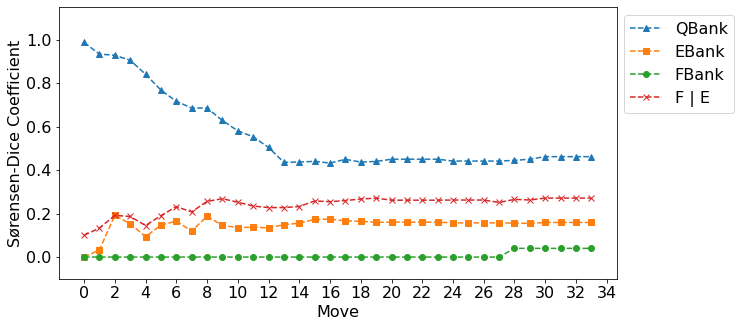

In [526]:
agg_qtrace,agg_etrace,agg_ftrace,agg_fuetrace = make_aggregate_traces(qtraces,etraces,ftraces,fuetraces)
    
font = {'size' : 16}

plt.rc('font', **font)

labels = ["QBank","EBank","FBank", "F | E"]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

ax.plot(agg_qtrace,'^--')
ax.plot(agg_etrace,'s--')
ax.plot(agg_ftrace,'o--')
ax.plot(agg_fuetrace,'x--')
ax.set_xlabel('Move')
ax.set_ylabel('Sørensen-Dice Coefficient')
ax.set_ylim(-.1, 1.15)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 2))
legend = ax.legend(labels=labels, loc="upper right", fontsize="16", bbox_to_anchor=(1.225, 1.0))
plt.show()